# CME Model of JCVI-syn3A Genetic Information Processes

In [1]:
from pyLM import *
from pyLM.units import *
from pySTDLM import *
from pySTDLM.PostProcessing import *
import math as m
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os

import seaborn as sns

import csv
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
import importlib
from collections import defaultdict, OrderedDict


## Load in model data such as the genome and proteomics

In [2]:
### Load all necessary files

# The annotation matches MMSYN1* IDs with JCVISYN3* IDs (or "locus tags").
annotatPD = pd.read_excel("../model_data/FBA/Syn3A_annotation_compilation.xls",
                         sheet_name="Syn3A_annotation_compilation_condensed")

# The genome data matches "locus tags" with AOE* protein IDs.
# It provides both the gene sequence, needed for transcription reactions in the ODE model,
# and the protein sequence, needed for translation reactions in the model.
# This is the NCBI Gene Bank-formated file (https://www.ncbi.nlm.nih.gov/nuccore/CP014992.1).

genomeFile2 = '../model_data/syn2.gb'
genome2 = next(SeqIO.parse(genomeFile2, "gb"))

# This is the NCBI Gene Bank-formated file (https://www.ncbi.nlm.nih.gov/nuccore/CP016816.2).
genomeFile3A = '../model_data/syn3A.gb'
genome3A = next(SeqIO.parse(genomeFile3A, "gb"))

# The proteomics matches AOE IDs with quantitative proteomics data.
proteomPD = pd.read_excel("../model_data/proteomics.xls", sheet_name="Proteomics", skiprows=[0] )


## Create Definitions to Get Protein Counts and Gene Sequences

In [3]:
# Create list of proteins with no proteomics data
ptnNoQuant = set()

def getPtnCount(newMetID, jcvi2ID):
    
    # Check if protein quantification is available.
    try:
        if jcvi2ID.startswith("JCVIman_"):
            aoeID = manGPRPD.loc[ manGPRPD.MM == jcvi2ID.replace("JCVIman_",""), "AOE" ].values[0]
        else:
            aoeID = J2toAOE[ jcvi2ID ]
        
        ptnCount = max(defaultPtnCount,round(proteomPD.loc[ proteomPD.Protein == aoeID ].iloc[0,21]))
#         
        ptnName  = proteomPD.loc[ proteomPD.Protein == aoeID ].iloc[0,1].replace(
            " [synthetic bacterium JCVI-Syn3.0]","")
        
#         ptnConcentration = ptnCount*countToMiliMol
    except:
        print("WARNING: No protein count for", newMetID)
        print("Using default protein concentration.")

        ptnName = newMetID
        ptnCount = defaultPtnCount
#         ptnConcentration = defaultPtnConcentration

        ptnNoQuant.add(newMetID)
    
    return ptnCount, ptnName

In [4]:
def getSequences(jcvi3AID):
    # returns genomic and protein sequences
    try:
        rnasequence = genomePtnLocDict[jcvi3AID].extract(genome3A.seq).transcribe()
        
        # Using translation table 11 from NCBI: "Bacterial, Archaeal and Plant Plastid Code"
        # https://www.ncbi.nlm.nih.gov/Taxonomy/Utils/wprintgc.cgi#SG4
        aasequence  = genomePtnLocDict[jcvi3AID].extract(genome3A.seq).transcribe().translate(table=4)
        
    except:
        aasequence  = 0
        rnasequence = 0
    
    return rnasequence, aasequence

In [5]:
# getSequences('JCVISYN3A_0001')

In [6]:
def getRNAsequences(jcvi3AID):
    # returns genomic and protein sequences
    try:
        rnasequence = genomeRnaLocDict[jcvi3AID].extract(genome3A.seq).transcribe()
        
    except:
        rnasequence = 0
    
    return rnasequence

In [7]:
AOEtoJ2 = dict()
J2toAOE = dict()
genomePtnLocDict = dict()
genomeRnaLocDict = dict()
Locus3A = []

for f in genome2.features:
    if f.type == "CDS":
        JCVSYN2_tag = f.qualifiers['locus_tag'][0]
        #print(JCVSYN2_tag)
        # Not all entries have an AOE protein_id
        if('protein_id' in f.qualifiers.keys()):
            AOE_locus = f.qualifiers['protein_id'][0]
            AOEtoJ2[AOE_locus] = JCVSYN2_tag
            J2toAOE[JCVSYN2_tag] = AOE_locus
#             genomeLocDict[JCVSYN2_tag] = f.location
        else:
            print("Locus ", JCVSYN2_tag, " has no AOE id!")
    if f.type == "rRNA":
        JCVSYN2_tag = f.qualifiers['locus_tag'][0]
#         genomeLocDict[JCVSYN2_tag] = f.location
    if f.type == "tRNA":
        JCVSYN2_tag = f.qualifiers['locus_tag'][0]
#         genomeLocDict[JCVSYN2_tag] = f.location
        
for f in genome3A.features:
    if f.type == "CDS":
        JCVSYN3A_tag = f.qualifiers['locus_tag'][0]
        Locus3A.append(JCVSYN3A_tag)
        #print(JCVSYN2_tag)
        # Not all entries have an AOE protein_id
        if('protein_id' in f.qualifiers.keys()):
#             AOE_locus = f.qualifiers['protein_id'][0]
#             AOEtoJ2[AOE_locus] = JCVSYN2_tag
#             J2toAOE[JCVSYN2_tag] = AOE_locus
            genomePtnLocDict[JCVSYN3A_tag] = f.location
        else:
            print("Locus ", JCVSYN3A_tag, " is pseudo.")
    if f.type == "rRNA":
        JCVSYN3A_tag = f.qualifiers['locus_tag'][0]
        Locus3A.append(JCVSYN3A_tag)
        genomeRnaLocDict[JCVSYN3A_tag] = f.location
    if f.type == "tRNA":
        JCVSYN3A_tag = f.qualifiers['locus_tag'][0]
        Locus3A.append(JCVSYN3A_tag)
        genomeRnaLocDict[JCVSYN3A_tag] = f.location

('Locus ', 'JCVSYN2_00155', ' has no AOE id!')
('Locus ', 'JCVSYN2_01555', ' has no AOE id!')
('Locus ', 'JCVSYN2_01600', ' has no AOE id!')
('Locus ', 'JCVSYN2_02325', ' has no AOE id!')
('Locus ', 'JCVISYN3A_0051', ' is pseudo.')
('Locus ', 'JCVISYN3A_0546', ' is pseudo.')
('Locus ', 'JCVISYN3A_0602', ' is pseudo.')


In [8]:
genomePtnLocDict

{'JCVISYN3A_0001': FeatureLocation(ExactPosition(0), ExactPosition(1353), strand=1),
 'JCVISYN3A_0002': FeatureLocation(ExactPosition(1510), ExactPosition(2638), strand=1),
 'JCVISYN3A_0003': FeatureLocation(ExactPosition(2674), ExactPosition(3217), strand=1),
 'JCVISYN3A_0004': FeatureLocation(ExactPosition(3206), ExactPosition(4007), strand=1),
 'JCVISYN3A_0005': FeatureLocation(ExactPosition(4063), ExactPosition(5155), strand=1),
 'JCVISYN3A_0006': FeatureLocation(ExactPosition(5514), ExactPosition(7419), strand=1),
 'JCVISYN3A_0007': FeatureLocation(ExactPosition(7434), ExactPosition(9939), strand=1),
 'JCVISYN3A_0008': FeatureLocation(ExactPosition(9990), ExactPosition(10968), strand=-1),
 'JCVISYN3A_0009': FeatureLocation(ExactPosition(10967), ExactPosition(13535), strand=-1),
 'JCVISYN3A_0010': FeatureLocation(ExactPosition(13524), ExactPosition(15141), strand=-1),
 'JCVISYN3A_0011': FeatureLocation(ExactPosition(15152), ExactPosition(16799), strand=-1),
 'JCVISYN3A_0012': Featu

## Initialize the Simulation

In [9]:
# Create our simulation object
sim=CME.CMESimulation(name="Min Cell Genetic Processes")

## Load Lists of Proteins for Metabolism and with Specific Naming in the model

In [10]:
PtnMetDF = pd.read_csv("../model_data/protein_metabolites.csv")
PtnMetDF

species         gene
0  M_apoACP_c  MMSYN1_0621
1   M_trdox_c  MMSYN1_0065
2    M_DnaA_c  MMSYN1_0001

In [11]:
riboPtnMetDF = pd.read_csv("../model_data/ribo_protein_metabolites.csv")
riboPtnMetDF

species         gene
0    M_s4_c  MMSYN1_0238
1   M_s17_c  MMSYN1_0662
2   M_s15_c  MMSYN1_0294
3    M_s8_c  MMSYN1_0657
4   M_s20_c  MMSYN1_0082
5    M_s7_c  MMSYN1_0149
6   M_s16_c  MMSYN1_0362
7   M_s18_c  MMSYN1_0025
8    M_s9_c  MMSYN1_0637
9   M_s13_c  MMSYN1_0647
10  M_s19_c  MMSYN1_0667
11   M_s2_c  MMSYN1_0540
12  M_s11_c  MMSYN1_0646
13   M_s5_c  MMSYN1_0654
14  M_s14_c  MMSYN1_0658
15   M_s3_c  MMSYN1_0665
16  M_s10_c  MMSYN1_0672
17  M_s12_c  MMSYN1_0148
18  M_s21_c  MMSYN1_0482
19  M_L24_c  MMSYN1_0660
20  M_L18_c  MMSYN1_0655
21  M_L11_c  MMSYN1_0810
22  M_L20_c  MMSYN1_0198
23  M_L12_c  MMSYN1_0806
24   M_L4_c  MMSYN1_0670
25  M_L21_c  MMSYN1_0501
26   M_L5_c  MMSYN1_0659
27   M_L1_c  MMSYN1_0809
28  M_L13_c  MMSYN1_0638
29  M_L29_c  MMSYN1_0663
30   M_L2_c  MMSYN1_0668
31  M_L31_c  MMSYN1_0137
32   M_L3_c  MMSYN1_0671
33  M_L22_c  MMSYN1_0666
34  M_L15_c  MMSYN1_0653
35  M_L34_c  MMSYN1_0910
36  M_L23_c  MMSYN1_0669
37   M_L6_c  MMSYN1_0656
38  M_L14_c  MMSYN1_0661
39  M_L19_c  MMSYN1_0365
40  M_L27_c  MMSYN1_0499
41  M_L10_c  MMSYN1_0807
42   M_L9_c  MMSYN1_0833
43  M_L16_c  MMSYN1_0664
44  M_L28_c  MMSYN1_0422
45  M_L32_c  MMSYN1_0526
46  M_L35_c  MMSYN1_0199
47  M_L17_c  MMSYN1_0644

In [12]:
RNApolPtnMetDF = pd.read_csv("../model_data/RNApol_proteins.csv")
RNApolPtnMetDF

species         gene
0  M_PTN_MMSYN1_0407_c  MMSYN1_0407
1  M_PTN_MMSYN1_0645_c  MMSYN1_0645
2  M_PTN_MMSYN1_0803_c  MMSYN1_0803
3  M_PTN_MMSYN1_0804_c  MMSYN1_0804

In [13]:
rrnaMetDF_1 = pd.read_csv("../model_data/rrna_metabolites_1.csv")
rrnaMetDF_1

species            gene
0   M_rRNA_5S_c  JCVISYN3A_0067
1  M_rRNA_23S_c  JCVISYN3A_0068
2  M_rRNA_16S_c  JCVISYN3A_0069

In [14]:
rrnaMetDF_2 = pd.read_csv("../model_data/rrna_metabolites_2.csv")
rrnaMetDF_2

species            gene
0   M_rRNA_5S_c  JCVISYN3A_0532
1  M_rRNA_23S_c  JCVISYN3A_0533
2  M_rRNA_16S_c  JCVISYN3A_0534

In [15]:
trnaMetDF = pd.read_csv("../model_data/trna_metabolites.csv")
trnaMetDF

species         gene
0   M_trnaleu_c  MMSYN1_0070
1   M_trnalys_c  MMSYN1_0071
2   M_trnaser_c  MMSYN1_0280
3   M_trnagly_c  MMSYN1_0295
4   M_trnaarg_c  MMSYN1_0374
5   M_trnaleu_c  MMSYN1_0423
6   M_trnaleu_c  MMSYN1_0506
7   M_trnalys_c  MMSYN1_0507
8   M_trnagln_c  MMSYN1_0508
9   M_trnatyr_c  MMSYN1_0509
10  M_trnathr_c  MMSYN1_0510
11  M_trnatrp_c  MMSYN1_0618
12  M_trnatrp_c  MMSYN1_0619
13  M_trnahis_c  MMSYN1_0624
14  M_trnaile_c  MMSYN1_0635
15  M_trnathr_c  MMSYN1_0678
16  M_trnaval_c  MMSYN1_0679
17  M_trnaglu_c  MMSYN1_0680
18  M_trnaasn_c  MMSYN1_0681
19  M_trnaarg_c  MMSYN1_0717
20  M_trnapro_c  MMSYN1_0718
21  M_trnaala_c  MMSYN1_0719
22  M_trnamet_c  MMSYN1_0720
23  M_trnamet_c  MMSYN1_0721
24  M_trnaser_c  MMSYN1_0722
25  M_trnamet_c  MMSYN1_0723
26  M_trnaasp_c  MMSYN1_0724
27  M_trnaphe_c  MMSYN1_0725
28  M_trnacys_c  MMSYN1_0828

In [16]:
MetPtnGenes = ['MMSYN1_0445', 'MMSYN1_0220',
 'MMSYN1_0131', 'MMSYN1_0727', 'MMSYN1_0607',
 'MMSYN1_0451', 'MMSYN1_0606', 'MMSYN1_0729',
 'MMSYN1_0213', 'MMSYN1_0221', 'MMSYN1_0495',
 'MMSYN1_0494', 'MMSYN1_0493', 'MMSYN1_0726',
 'MMSYN1_0435', 'MMSYN1_0475', 'MMSYN1_0227',
 'MMSYN1_0228', 'MMSYN1_0229', 'MMSYN1_0230',
 'MMSYN1_0316', 'MMSYN1_0262', 'MMSYN1_0800',
 'MMSYN1_0831', 'MMSYN1_0733', 'MMSYN1_0732',
 'MMSYN1_0432', 'MMSYN1_0381', 'MMSYN1_0687',
 'MMSYN1_0688', 'MMSYN1_0689', 'MMSYN1_0012',
 'MMSYN1_0519', 'MMSYN1_0260', 'MMSYN1_0634',
 'MMSYN1_0837', 'MMSYN1_0126', 'MMSYN1_0535',
 'MMSYN1_0613', 'MMSYN1_0308', 'MMSYN1_0061',
 'MMSYN1_0222', 'MMSYN1_0282', 'MMSYN1_0287',
 'MMSYN1_0076', 'MMSYN1_0064', 'MMSYN1_0288',
 'MMSYN1_0528', 'MMSYN1_0529', 'MMSYN1_0163',
 'MMSYN1_0405', 'MMSYN1_0614', 'MMSYN1_0380',
 'MMSYN1_0378', 'MMSYN1_0259', 'MMSYN1_0291',
 'MMSYN1_0823', 'MMSYN1_0684', 'MMSYN1_0390',
 'MMSYN1_0799', 'MMSYN1_0443', 'MMSYN1_0413',
 'MMSYN1_0747', 'MMSYN1_0651', 'MMSYN1_0771',
 'MMSYN1_0772', 'MMSYN1_0773', 'MMSYN1_0819',
 'MMSYN1_0344', 'MMSYN1_0330', 'MMSYN1_0382',
 'MMSYN1_0216', 'MMSYN1_0203', 'MMSYN1_0798',
 'MMSYN1_0537', 'MMSYN1_0347', 'MMSYN1_0140',
 'MMSYN1_0045', 'MMSYN1_0129', 'MMSYN1_0515',
 'MMSYN1_0447', 'MMSYN1_0218', 'MMSYN1_0513',
 'MMSYN1_0139', 'MMSYN1_0420', 'MMSYN1_0616',
 'MMSYN1_0617', 'MMSYN1_0419', 'MMSYN1_0117',
 'MMSYN1_0512', 'MMSYN1_0304', 'MMSYN1_0875',
 'MMSYN1_0214', 'MMSYN1_0147', 'MMSYN1_0115',
 'MMSYN1_0813', 'MMSYN1_0814', 'MMSYN1_0114',
 'MMSYN1_0697', 'MMSYN1_0113']
# MetPtnGenes

MetLocusNums = []

for gene in MetPtnGenes:
    locusNum = gene.split('_')[1]
    MetLocusNums.append(locusNum)
    
# MetLocusNums

In [17]:
named_PTN_list = []

for index, row in riboPtnMetDF.iterrows():
    named_PTN_list.append(row["gene"]) 

    
for index, row in PtnMetDF.iterrows():
    named_PTN_list.append(row["gene"])

## Define Transcription and Translation Rate Constants

In [18]:
ModelSpecies = []

In [19]:
defaultPtnCount = 1

In [20]:
baseMap = OrderedDict({ "A":"M_atp_c", "U":"M_utp_c", "G":"M_gtp_c", "C":"M_ctp_c" })
# baseMapToMonoP = OrderedDict({ "A":"M_amp_c", "U":"M_ump_c", "G":"M_gmp_c", "C":"M_cmp_c" })

# Global parameters for transcription
rnaPolKcat = 0.155*187/493*25 # nt/s
rnaPolK0 = 1e-4 #mM
rnaPolKd = 0.01 #mM

rrnaPolKcat = 90*2 # nt/s

krnadeg = 0.00578/2 # 1/s
ptnDegRate = 7.70e-06 # 1/s

ATPconc = 1.04 #mM
UTPconc = 0.68 #mM
CTPconc = 0.34 #mM
GTPconc = 0.68 #mM

# Cell radius (meters):
# r_cell = 2.5*(10**-7)
r_cell = 2.0*(10**-7) # m

CytoVolume = (4*np.pi/3)*1000*r_cell**3 # L
cellVolume = CytoVolume

# print(cellVolume)

# Avogadro:
avgdr   = 6.022e23 # molec/mol
Avognum = avgdr

countToMiliMol = 1000/(avgdr*cellVolume)

RnaPconc = 187*countToMiliMol # mM

# Global parameter for degradation of mRNAs
rnaDegRate = 0.00578/2 # 1/s

# Create a map for rna sequence to NTP concentration.
baseMap = OrderedDict({ "A":ATPconc, "U":UTPconc, "G":GTPconc, "C":CTPconc })

# Create Dictionaries to map tRNAs to associated aa abbreviations in protein sequences.
aaMap = OrderedDict({"A":"M_ala__L_c", "R":"M_arg__L_c", 
    "N":"M_asn__L_c", "D":"M_asp__L_c", "C":"M_cys__L_c", "E":"M_glu__L_c", "Q":"M_gln__L_c", "G":"M_gly_c", 
    "H":"M_his__L_c", "I":"M_ile__L_c", "L":"M_leu__L_c", "K":"M_lys__L_c", "M":"M_met__L_c", "F":"M_phe__L_c", 
    "P":"M_pro__L_c", "S":"M_ser__L_c", "T":"M_thr__L_c", "W":"M_trp__L_c", "Y":"M_tyr__L_c", "V":"M_val__L_c",
    "*":"Stop_Codon"})

aaTRNAMap = OrderedDict({"A":"M_alatrna_c", "R":"M_argtrna_c", 
    "N":"M_asntrna_c", "D":"M_asptrna_c", "C":"M_cystrna_c", "E":"M_glutrna_c", "Q":"M_glntrna_c", "G":"M_glytrna_c", 
    "H":"M_histrna_c", "I":"M_iletrna_c", "L":"M_leutrna_c", "K":"M_lystrna_c", "M":"M_mettrna_c", "F":"M_phetrna_c", 
    "P":"M_protrna_c", "S":"M_sertrna_c", "T":"M_thrtrna_c", "W":"M_trptrna_c", "Y":"M_tyrtrna_c", "V":"M_valtrna_c"})

aaTRNAFreeMap = OrderedDict({"A":"M_trnaala_c", "R":"M_trnaarg_c", 
    "N":"M_trnaasn_c", "D":"M_trnaasp_c", "C":"M_trnacys_c", "E":"M_trnaglu_c", "Q":"M_trnagln_c", "G":"M_trnagly_c", 
    "H":"M_trnahis_c", "I":"M_trnaile_c", "L":"M_trnaleu_c", "K":"M_trnalys_c", "M":"M_trnamet_c", "F":"M_trnaphe_c", 
    "P":"M_trnapro_c", "S":"M_trnaser_c", "T":"M_trnathr_c", "W":"M_trnatrp_c", "Y":"M_trnatyr_c", "V":"M_trnaval_c"})


# Global parameters for translation
riboKcat = 5 # 1/s
riboK0 = 4*25e-6 # 
riboKd = 0.0001 # 

ribosomeConc = 500*countToMiliMol # mM

# Concentration of charged tRNA
ctRNAconc = 150*countToMiliMol # mM

# Global parameter for degradation of proteins
# Derived from eLife's model, using average protein half life of 25 hours. 
ptnDegRate = 7.70e-06 # 1/s


In [21]:
# Define how to calculate transcription rate constants as in equation 3 for transcription reactions.
# Uses mature transcript length and proteomics for promoter strength.

def TranscriptRate(rnaMetID, ptnMetID, rnasequence, jcvi2ID):
    # Add trascription reaction
    
    # Check that we know all bases used in the sequence
    if ( set(rnasequence) - set(baseMap.keys()) ):
        raise Exception("Unknown base(s) in RNA sequence {}".format(set(rnasequence) - set(baseMap.keys())) )
    
    # Count how many times each base is used
    baseCount = defaultdict(int)
    for base in set(rnasequence):
        baseCount[base] = rnasequence.count(base)
    

    ptnCount, ptnName = getPtnCount(ptnMetID, jcvi2ID)
    
    kcat_mod = min(rnaPolKcat*(ptnCount/(180)),2*90)

    
    # Add total number of monomers to parameter dict
    
    CMono1 = baseMap[ rnasequence[0] ]
    
    CMono2 = baseMap[ rnasequence[1] ]

    n_tot = sum(list(baseCount.values()))

    NMono_A = baseCount["A"]
    
    NMono_U = baseCount["C"]
    
    NMono_C = baseCount["G"]
    
    NMono_G = baseCount["U"]
    
    NMonoDict = [NMono_A,NMono_C,NMono_G,NMono_U]
    print(NMonoDict)
    
    
    NMonoSum = NMono_A*rnaPolKd/ATPconc + NMono_C*rnaPolKd/CTPconc + NMono_U*rnaPolKd/UTPconc + NMono_G*rnaPolKd/GTPconc
    

    k_transcription = kcat_mod / ((1+rnaPolK0/RnaPconc)*(rnaPolKd**2)/(CMono1*CMono2) + NMonoSum + n_tot - 1)
    
    return k_transcription


In [22]:
# Define transcription rate for ribosomal protein-coding genes.

def riboTranscriptRate(rnaMetID, ptnMetID, rnasequence, jcvi2ID):
    # Add trascription reaction
    
    # Check that we know all bases used in the sequence
    if ( set(rnasequence) - set(baseMap.keys()) ):
        raise Exception("Unknown base(s) in RNA sequence {}".format(set(rnasequence) - set(baseMap.keys())) )
    
    # Count how many times each base is used
    baseCount = defaultdict(int)
    for base in set(rnasequence):
        baseCount[base] = rnasequence.count(base)
        
    ptnCount, ptnName = getPtnCount(ptnMetID, jcvi2ID)
    
#     kcat_mod = min(rnaPolKcat*(ptnCount/(180)),2*85)
    
    kcat_mod = rnaPolKcat#*(339/(180))
    
    # The rate form needs specific sequence data for the first two monomers:
#     paramDict["CMonoA"] = baseMap[ rnasequence[0] ]
#     paramDict["CMonoB"] = baseMap[ rnasequence[1] ]
#     paramDict["KDA"] = rnaPolKd # Since we are current;y using the same Kd for all nucleotides
#     paramDict["KDB"] = rnaPolKd 
    
    # Add total number of monomers to parameter dict

    n_tot = sum(list(baseCount.values()))

    NMono_A = baseCount["A"]
    
    NMono_U = baseCount["C"]
    
    NMono_C = baseCount["G"]
    
    NMono_G = baseCount["U"]
    
    NMonoDict = [NMono_A,NMono_C,NMono_G,NMono_U]
    print(NMonoDict)
    
    CMono1 = baseMap[ rnasequence[0] ]
    
    CMono2 = baseMap[ rnasequence[1] ]
    
    NMonoSum = NMono_A*rnaPolKd/ATPconc + NMono_C*rnaPolKd/CTPconc + NMono_U*rnaPolKd/UTPconc + NMono_G*rnaPolKd/GTPconc

    k_transcription = kcat_mod / ((1+rnaPolK0/RnaPconc)*(rnaPolKd**2)/(CMono1*CMono2) + NMonoSum + n_tot - 1)
    
    return k_transcription

In [23]:
# Define transcription rate for tRNA genes.

def trnaTranscriptRate(rnaMetID, rnasequence):
    # Add trascription reaction
    
    # Check that we know all bases used in the sequence
    if ( set(rnasequence) - set(baseMap.keys()) ):
        raise Exception("Unknown base(s) in RNA sequence {}".format(set(rnasequence) - set(baseMap.keys())) )
    
    # Count how many times each base is used
    baseCount = defaultdict(int)
    for base in set(rnasequence):
        baseCount[base] = rnasequence.count(base)
    
    # The rate form needs specific sequence data for the first two monomers:
#     paramDict["CMonoA"] = baseMap[ rnasequence[0] ]
#     paramDict["CMonoB"] = baseMap[ rnasequence[1] ]
#     paramDict["KDA"] = rnaPolKd # Since we are current;y using the same Kd for all nucleotides
#     paramDict["KDB"] = rnaPolKd 
    
    # Add total number of monomers to parameter dict

    n_tot = sum(list(baseCount.values()))

    NMono_A = baseCount["A"]
    
    NMono_U = baseCount["C"]
    
    NMono_C = baseCount["G"]
    
    NMono_G = baseCount["U"]
    
    NMonoDict = [NMono_A,NMono_C,NMono_G,NMono_U]
    print(NMonoDict)
    
    CMono1 = baseMap[ rnasequence[0] ]
    
    CMono2 = baseMap[ rnasequence[1] ]
    
    NMonoSum = NMono_A*rnaPolKd/ATPconc + NMono_C*rnaPolKd/CTPconc + NMono_U*rnaPolKd/UTPconc + NMono_G*rnaPolKd/GTPconc
    
    k_transcription = rnaPolKcat/ ((1+rnaPolK0/RnaPconc)*(rnaPolKd**2)/(CMono1*CMono2) + NMonoSum + n_tot - 1)
    
    return k_transcription

In [24]:
# Define transcription rate for tRNA genes.

def rrnaTranscriptRate(rnasequence):
    # Add trascription reaction
    
    # Check that we know all bases used in the sequence
    if ( set(rnasequence) - set(baseMap.keys()) ):
        raise Exception("Unknown base(s) in RNA sequence {}".format(set(rnasequence) - set(baseMap.keys())) )
    
    # Count how many times each base is used
    baseCount = defaultdict(int)
    for base in set(rnasequence):
        baseCount[base] = rnasequence.count(base)
    
    # The rate form needs specific sequence data for the first two monomers:
#     paramDict["CMonoA"] = baseMap[ rnasequence[0] ]
#     paramDict["CMonoB"] = baseMap[ rnasequence[1] ]
#     paramDict["KDA"] = rnaPolKd # Since we are current;y using the same Kd for all nucleotides
#     paramDict["KDB"] = rnaPolKd 
    
    # Add total number of monomers to parameter dict
#     paramDict["n"] = sum(list(baseCount.values()))
    n_tot = sum(list(baseCount.values()))
    
    NMono_A = baseCount["A"]
    
    NMono_U = baseCount["C"]
    
    NMono_C = baseCount["G"]
    
    NMono_G = baseCount["U"]
    
    NMonoDict = [NMono_A,NMono_C,NMono_G,NMono_U]
    print(NMonoDict)
    
    CMono1 = baseMap[ rnasequence[0] ]
    
    CMono2 = baseMap[ rnasequence[1] ]
    
    NMonoSum = NMono_A*rnaPolKd/ATPconc + NMono_C*rnaPolKd/CTPconc + NMono_U*rnaPolKd/UTPconc + NMono_G*rnaPolKd/GTPconc
    
    k_transcription = rrnaPolKcat / ((1+rnaPolK0/RnaPconc)*(rnaPolKd**2)/(CMono1*CMono2) + NMonoSum + n_tot - 1)
    
    return k_transcription

In [25]:
# Define how to calculate translation rate constants as in equation 3 for translation reactions.

def TranslatRate(rnaMetID, ptnMetID, rnasequence, aasequence):
    # Add translation reaction
    
    # Considers amino acids up to the first stop codon.
#     aasequence = aasequence[0:aasequence.find("*")]
    
    # Check that we know all residues used in the sequence
    if ( set(aasequence) - set(aaMap.keys()) ):
        raise Exception("Unknown residue(s) in Protein sequence {}".format(set(aasequence) - set(aaMap.keys())) )
    
    # Count how many times each residue is used
    aaCount = defaultdict(int)
    for aa in set(aasequence):
        aaCount[aa] = aasequence.count(aa)
    
    NMono_A = aaCount["A"]
    NMono_R = aaCount["R"]
    NMono_N = aaCount["N"]
    NMono_D = aaCount["D"]
    NMono_C = aaCount["C"]
    NMono_E = aaCount["E"]
    NMono_Q = aaCount["Q"]
    NMono_H = aaCount["H"]
    NMono_I = aaCount["I"]
    NMono_L = aaCount["L"]
    NMono_K = aaCount["K"]
    NMono_M = aaCount["M"]
    NMono_P = aaCount["P"]
    NMono_S = aaCount["S"]
    NMono_T = aaCount["T"]
    NMono_W = aaCount["W"]
    NMono_Y = aaCount["Y"]
    NMono_G = aaCount["G"]
    NMono_F = aaCount["F"]
    NMono_V = aaCount["V"]
    
    NStop = aaCount["*"]
    
    if NStop > 1:
        print("EXTRA STOP CODON: MISTAKE IN TRANSLATION")
    
    NMonoDict = [NMono_A,NMono_R,NMono_N,NMono_D,NMono_C,NMono_E,NMono_Q,NMono_H,
                 NMono_I,NMono_L,NMono_K,NMono_M,NMono_P,NMono_S,NMono_T,NMono_W,
                 NMono_Y,NMono_G,NMono_F,NMono_V]
    
    NMonoSum = 0
    
    for nmono in range(0,len(NMonoDict)):
        NMonoSum = NMonoSum + NMonoDict[nmono]*riboKd/ctRNAconc
        
    n_tot = sum(list(aaCount.values()))

    baseCount = defaultdict(int)
    for base in set(rnasequence):
        baseCount[base] = rnasequence.count(base)
        
    transcript_length = sum(list(baseCount.values()))
    
    print(transcript_length)
    
    ribo_num = max(1,int(transcript_length/300)) #max(1,int(transcript_length/300))
    
    print(ribo_num)
    
    kcat_mod = riboKcat*ribo_num #*0.4
    
    k_translation = kcat_mod / ((1+riboK0/ribosomeConc)*(riboKd**2)/(ctRNAconc**2) + NMonoSum + n_tot - 1)
    
    return k_translation


## Create Definitions to Add RNA, Proteins, and Reactions to the Simulation

In [26]:

def addPtn(jcvi3AID):
    locusNum = jcvi3AID.split('_')[1]
    mmcode = 'MMSYN1_' + locusNum
    # Checks if a translation to JCVISYN2* code is available
    try:
        jcvi2ID = annotatPD.loc[ annotatPD.iloc[:,5] == mmcode ].iloc[0, 13].strip()
    except:
        jcvi2ID = "JCVIunk_" + mmcode

    print(mmcode, jcvi2ID, jcvi3AID)
    
    genes_in_model.append(jcvi3AID)

    ptnMetID = 'M_PTN_' + jcvi3AID + '_c'
    # If the protein is not in the model, add it:

    ModelSpecies.append(ptnMetID)

    ptnCount, ptnName = getPtnCount(ptnMetID, jcvi2ID)

    print(ptnMetID, ptnCount)

    geneMetID = jcvi3AID + '_gene'
    
    ModelSpecies.append(geneMetID)

    # Get nucleotide and amino acid sequences, if available
    rnasequence, aasequence = getSequences(jcvi3AID)
    print(rnasequence)
    print(aasequence)

    if (rnasequence != 0) and (aasequence != 0):

        rnaMetID = "M_RNA_" + jcvi3AID + "_c"
        rnaName = "(mRNA) " + ptnName

        ModelSpecies.append(rnaMetID)
    
        species = []
        species = [geneMetID, rnaMetID, ptnMetID]
        print(species)
        sim.defineSpecies(species)

        sim.addParticles(species = geneMetID, count = 1)
        sim.addParticles(species = ptnMetID,  count = int(ptnCount))
        sim.addParticles(species = rnaMetID, count = 1)
        
        TrscProd = [geneMetID,rnaMetID]
        mRNAdegProd = []
    
        for i in range(len(rnasequence)):
            TrscProd.append('ATP_trsc')
            mRNAdegProd.append('ATP_mRNAdeg')
            
        TranslatProd = [rnaMetID,ptnMetID]
        ptnDegProd = []
        
        for i in range(len(aasequence)):
            TranslatProd.append('ATP_translat')
            TranslatProd.append('ATP_translat')
            ptnDegProd.append('ATP_ptndeg')
    
        sim.addReaction(geneMetID, tuple(TrscProd), TranscriptRate(rnaMetID, ptnMetID, rnasequence, jcvi2ID))
        sim.addReaction(rnaMetID, tuple(mRNAdegProd) ,krnadeg)
        sim.addReaction(rnaMetID, tuple(TranslatProd), TranslatRate(rnaMetID, ptnMetID, rnasequence, aasequence))
        
        sim.addReaction(ptnMetID,tuple(ptnDegProd),ptnDegRate)


In [27]:

def addNamedPtn(newMetID, mmcode):
    
    locusNum = mmcode.split('_')[1]

    jcvi3AID = 'JCVISYN3A_' + locusNum
    
    genes_in_model.append(jcvi3AID)

    # Checks if a translation to JCVISYN2* code is available
    try:
        jcvi2ID = annotatPD.loc[ annotatPD.iloc[:,5] == mmcode ].iloc[0, 13].strip()
    except:
        # If not, check for a manual AOE connection:
        if mmcode in manGPRPD.MM.values:
            jcvi2ID = "JCVIman_" + mmcode
        else:
            # If not, set an "unknown" code
            jcvi2ID = "JCVIunk_" + mmcode + "_" + str(unkIter)

    print(mmcode, jcvi2ID, jcvi3AID)

    ptnCount, ptnName = getPtnCount(newMetID, jcvi2ID)
    
    ModelSpecies.append(newMetID)

    print(newMetID, ptnCount)


    geneMetID = jcvi3AID + '_gene'

    ModelSpecies.append(geneMetID)
    
    rnasequence, aasequence = getSequences(jcvi3AID)
    print(rnasequence)
    print(aasequence)

    if (rnasequence != 0) and (aasequence != 0):

        rnaMetID = "M_RNA_" + jcvi3AID + "_c"
        rnaName = "(mRNA) " + ptnName
        
    ModelSpecies.append(rnaMetID)

    species = []
    species = [geneMetID, rnaMetID, newMetID]
    print(species)
    sim.defineSpecies(species)

    sim.addParticles(species = geneMetID, count = 1)
    sim.addParticles(species = newMetID,  count = int(ptnCount))
    sim.addParticles(species = rnaMetID, count = 1)
    
    TrscProd = [geneMetID,rnaMetID]
    mRNAdegProd = []
    
    for i in range(len(rnasequence)):
        TrscProd.append('ATP_trsc')
        mRNAdegProd.append('ATP_mRNAdeg')
        
    TranslatProd = [rnaMetID,newMetID]
    ptnDegProd = []
        
    for i in range(len(aasequence)):
        TranslatProd.append('ATP_translat')
        TranslatProd.append('ATP_translat')
        ptnDegProd.append('ATP_ptndeg')
    
    sim.addReaction(geneMetID, tuple(TrscProd), TranscriptRate(rnaMetID, newMetID, rnasequence, jcvi2ID))
    sim.addReaction(rnaMetID, tuple(mRNAdegProd) ,krnadeg)
    sim.addReaction(rnaMetID, tuple(TranslatProd), TranslatRate(rnaMetID, newMetID, rnasequence, aasequence))

    sim.addReaction(newMetID,tuple(ptnDegProd),ptnDegRate)


In [28]:
RiboPtnNames = ['Ribosomal Protein']
RiboPtnLens = ['Gene Length (nt)']
RiboPtnTrscRates = ['Transcription Rate']
RiboPtnTranslatRates = ['Translation Rate']

def addRiboPtn(newMetID, mmcode):
    
    locusNum = mmcode.split('_')[1]

    jcvi3AID = 'JCVISYN3A_' + locusNum

    genes_in_model.append(jcvi3AID)

    # Checks if a translation to JCVISYN2* code is available
    try:
        jcvi2ID = annotatPD.loc[ annotatPD.iloc[:,5] == mmcode ].iloc[0, 13].strip()
    except:
        # If not, check for a manual AOE connection:
        if mmcode in manGPRPD.MM.values:
            jcvi2ID = "JCVIman_" + mmcode
        else:
            # If not, set an "unknown" code
            jcvi2ID = "JCVIunk_" + mmcode + "_" + str(unkIter)
            unkIter += 1 

    print(mmcode, jcvi2ID, jcvi3AID)

    ptnCount, ptnName = getPtnCount(newMetID, jcvi2ID)

    print(newMetID, ptnCount)
    
    ModelSpecies.append(newMetID)

    geneMetID = jcvi3AID + '_gene'

    ModelSpecies.append(geneMetID)
    
    rnasequence, aasequence = getSequences(jcvi3AID)
    print(rnasequence)
    print(aasequence)

    if (rnasequence != 0) and (aasequence != 0):

        rnaMetID = "M_RNA_" + jcvi3AID + "_c"
        rnaName = "(mRNA) " + ptnName
        
    ModelSpecies.append(rnaMetID)

    species = []
    species = [geneMetID, rnaMetID, newMetID]
    print(species)
    sim.defineSpecies(species)

    sim.addParticles(species = geneMetID, count = 1)
    sim.addParticles(species = newMetID,  count = int(ptnCount))
    sim.addParticles(species = rnaMetID, count = 1)
    
    RiboPtnNames.append(newMetID)
    
    trsc_rate = riboTranscriptRate(rnaMetID, newMetID, rnasequence, jcvi2ID)
    RiboPtnTrscRates.append(trsc_rate)
    
    translat_rate = TranslatRate(rnaMetID, newMetID, rnasequence, aasequence)
    RiboPtnTranslatRates.append(translat_rate)
    
    rna_length = len(rnasequence)
    RiboPtnLens.append(rna_length)
    
    TrscProd = [geneMetID,rnaMetID]
    mRNAdegProd = []
    
    for i in range(len(rnasequence)):
        TrscProd.append('ATP_trsc')
        mRNAdegProd.append('ATP_mRNAdeg')
        
    TranslatProd = [rnaMetID,newMetID]
        
    for i in range(len(aasequence)):
        TranslatProd.append('ATP_translat')
        TranslatProd.append('ATP_translat')
    
    sim.addReaction(geneMetID, tuple(TrscProd), riboTranscriptRate(rnaMetID, newMetID, rnasequence, jcvi2ID))
    sim.addReaction(rnaMetID, tuple(mRNAdegProd) ,krnadeg)
    sim.addReaction(rnaMetID, tuple(TranslatProd), TranslatRate(rnaMetID, newMetID, rnasequence, aasequence))


In [29]:
tRNAadded = []

def addtRNA(newMetID, mmcode):
    
    locusNum = mmcode.split('_')[1]

    jcvi3AID = 'JCVISYN3A_' + locusNum

    # Checks if a translation to JCVISYN2* code is available
    try:
        jcvi2ID = annotatPD.loc[ annotatPD.iloc[:,5] == mmcode ].iloc[0, 13].strip()
    except:
        # If not, check for a manual AOE connection:
        if mmcode in manGPRPD.MM.values:
            jcvi2ID = "JCVIman_" + mmcode
        else:
            # If not, set an "unknown" code
            jcvi2ID = "JCVIunk_" + mmcode + "_" + str(unkIter)
            unkIter += 1 

    print(jcvi3AID)

    geneMetID = jcvi3AID + '_gene'
    
    ModelSpecies.append(geneMetID)

    rnasequence = getRNAsequences(jcvi3AID)
    print(rnasequence)

    gene = [geneMetID]
    print(gene)
    sim.defineSpecies(gene)

    sim.addParticles(species = geneMetID, count = 1)

    
    if newMetID not in tRNAadded:
        ModelSpecies.append(newMetID)
        tRNA = [newMetID]
        sim.defineSpecies(tRNA)
        sim.addParticles(species = newMetID,  count = 38)
        tRNAadded.append(newMetID)
        
    Products = [geneMetID,newMetID]
        
    for i in range(len(rnasequence)):
        Products.append('ATP_trsc')
        
    
    sim.addReaction(geneMetID, tuple(Products), trnaTranscriptRate(newMetID, rnasequence))


In [30]:
def addrRNA():
    
    rrna_gene_locs_1 = []
    rrna_gene_locs_2 = []

    rRNA_species = []
    
    for index, row in rrnaMetDF_1.iterrows():
        newMetID = row["species"]
        jcvi3AID = row["gene"]
        
#         rnasequence = getRNAsequences(jcvi3AID)
        gene_str = str(genomeRnaLocDict[jcvi3AID])
        start_nt = int(gene_str.split(':')[0].replace('[',''))
        print(start_nt)
        end_nt = int(gene_str.split(':')[1].replace('](-)',''))
        print(end_nt)
        rrna_gene_locs_1.append(start_nt)
        rrna_gene_locs_1.append(end_nt)
            
        rRNA_species.append(newMetID)
        
    rrna_pos_1 = Seq(str(genome3A.seq[min(rrna_gene_locs_1):max(rrna_gene_locs_1)]))
    
    rrna_operon_1 = rrna_pos_1.reverse_complement()
            
    print(rrna_operon_1)
    
    
    for index, row in rrnaMetDF_2.iterrows():
        newMetID = row["species"]
        jcvi3AID = row["gene"]
        
#         rnasequence = getRNAsequences(jcvi3AID)
        gene_str = str(genomeRnaLocDict[jcvi3AID])
        start_nt = int(gene_str.split(':')[0].replace('[',''))
        print(start_nt)
        end_nt = int(gene_str.split(':')[1].replace('](-)',''))
        print(end_nt)
        rrna_gene_locs_2.append(start_nt)
        rrna_gene_locs_2.append(end_nt)
        
    rrna_pos_2 = Seq(str(genome3A.seq[min(rrna_gene_locs_2):max(rrna_gene_locs_2)]))
    
    rrna_operon_2 = rrna_pos_2.reverse_complement()
            
    print(rrna_operon_2)
    
    print(rRNA_species)
    
    sim.defineSpecies(rRNA_species)
    
    
    for rRNA in rRNA_species:
        
        sim.addParticles(species = rRNA,  count = 1)
            
        ModelSpecies.append(rRNA)
    
    
    
    for index, row in rrnaMetDF_1.iterrows():
        newMetID = row["species"]
        jcvi3AID = row["gene"]
        
        geneMetID = jcvi3AID + '_gene'
    
        ModelSpecies.append(geneMetID)
        
        gene = [geneMetID]
        print(gene)
        sim.defineSpecies(gene)

        sim.addParticles(species = geneMetID, count = 1)

        print(jcvi3AID)

        rnasequence = rrna_operon_1.transcribe()
        
        TrscProd = [geneMetID,newMetID]
        
        for i in range(int(len(rnasequence)/3)):
            TrscProd.append('ATP_trsc')
            
        sim.addReaction(geneMetID, tuple(TrscProd), rrnaTranscriptRate(rnasequence))
        
        
    for index, row in rrnaMetDF_2.iterrows():
        newMetID = row["species"]
        jcvi3AID = row["gene"]
        
        geneMetID = jcvi3AID + '_gene'
    
        ModelSpecies.append(geneMetID)
        
        gene = [geneMetID]
        print(gene)
        sim.defineSpecies(gene)

        sim.addParticles(species = geneMetID, count = 1)

        print(jcvi3AID)

        rnasequence = rrna_operon_2.transcribe()
        
        TrscProd = [geneMetID,newMetID]
        
        for i in range(int(len(rnasequence)/3)):
            TrscProd.append('ATP_trsc')
        
        sim.addReaction(geneMetID, tuple(TrscProd), rrnaTranscriptRate(rnasequence))
    

In [31]:
# REPLICATION INITIATION WRITTEN BY COLE CROTTY AND MODIFIED BY ZANE THORNBURG
NA = 6.022*(10**(23))

def addRepInit():
    k_high = 7800*1000/NA/cellVolume
    k_low = 35*1000/NA/cellVolume
    k_on = 100*1000/NA/cellVolume #molecule^-1 sec^-1
    k_off = 0.55 #sec^-1
    
    helicase_removal_rate = 600 #s^-1
    
    nonOricSpec = ['High_Affinity_Site','High_Affinity_Bound','High_Affinity_Site_oriC','High_Affinity_Bound_oriC','Low_Affinity_Site_1','Low_Affinity_Site_2','Low_Affinity_Bound_1','Low_Affinity_Bound_2']
    sim.defineSpecies(nonOricSpec)
    sim.addParticles(species = 'High_Affinity_Site', count = 16)
    sim.addParticles(species = 'High_Affinity_Bound', count = 0)
    sim.addReaction(('High_Affinity_Site', 'M_DnaA_c'),'High_Affinity_Bound',k_high)
    
    sim.addParticles(species = 'High_Affinity_Site_oriC', count = 1)
    sim.addParticles(species = 'Low_Affinity_Site_1', count = 0)
    sim.addParticles(species = 'Low_Affinity_Site_2', count = 0)
    
    sim.addReaction(('High_Affinity_Site_oriC', 'M_DnaA_c'),('High_Affinity_Bound_oriC','Low_Affinity_Site_1'),k_high)
    sim.addReaction(('Low_Affinity_Site_1', 'M_DnaA_c'),('Low_Affinity_Bound_1','Low_Affinity_Site_2'),k_low)
    sim.addReaction(('Low_Affinity_Site_2', 'M_DnaA_c'),('Low_Affinity_Bound_2','ssDNAunboundSite_1'),k_low)

    species = []

    for i in range(30):         #loop adds 30 terms for unbound sites
        term = 'ssDNAunboundSite_'
        term = term + str(i+1)
        species.append(term)
    for j in range(30):         #adds 30 more terms of Bound sites
        bnd = 'ssDNABoundSite_'
        bnd = bnd + str(j+1)
        species.append(bnd)
    for k in range(30):
        unbnd = 'ssDNA_Unbinding_'
        unbnd = unbnd + str(k+1)
        species.append(unbnd)
        
    species.append('Initiator')

    sim.defineSpecies(species)

    for specy in species:
        sim.addParticles(species = specy, count = 0) #gives all particles count of 0 

    sim.addParticles(species = 'ssDNAunboundSite_1', count = 0) #starts at 1(only site existing @ start
    
    # Bidning and unbinding reactions are constructed so that DnaA in the middle of the filament cannot unbind and
    # DnaA only bind next to the last DnaA in the filament.

    # Add the binding reactions for each of the 30 binding events in filament formation.
    for i in range (1,30):
        sim.addReaction(('ssDNAunboundSite_' + str(i),'M_DnaA_c'), ('ssDNAunboundSite_' + str(i+1),'ssDNABoundSite_' + str(i)),k_on)
        sim.addReaction(('ssDNAunboundSite_' + str(i+1), 'ssDNABoundSite_' + str(i)),('ssDNAunboundSite_' + str(i),'M_DnaA_c'),k_off)

    sim.addReaction(('ssDNAunboundSite_30', 'M_DnaA_c'),('ssDNABoundSite_30','ssDNA_Unbinding_30','Initiator'),k_on)
    
    # Add the unbinding reactions for each of the 30 possible unbinding events in filament formation.
    for i in range (2,31):
        sim.addReaction(('ssDNA_Unbinding_' + str(i), 'ssDNABoundSite_' + str(i)),('ssDNA_Unbinding_' + str(i-1),'M_DnaA_c'),helicase_removal_rate)
        
    sim.addReaction(('ssDNA_Unbinding_1', 'ssDNABoundSite_1'),'M_DnaA_c',helicase_removal_rate)

In [32]:
# Add replication reaction to duplicate each gene in the model.
# The model is constucted so that replication cannot occur before completion of replication initiation.
# The species "chromosome" is used to ensure the genome is only duplicated once.  It is a placeholder to say
# the original genome is duplicated.

def addReplication():
    Total_genes = 0
    K0rep = 0.26e-3
    KDrep = 0.001
    kcatrep = 600
    datp = 0.009*2 # mM
    dttp = 0.011*2 # mM
    dctp = 0.006*2 # mM
    dgtp = 0.0035*2 # mM
    DNApol3 = 35*countToMiliMol # mM
    RepRate = kcatrep/((1+K0rep/DNApol3)*(KDrep**2/datp/dttp) + 203606*KDrep/2/datp + 207816*KDrep/2/dttp + 67238*KDrep/2/dctp + 64720*KDrep/2/dgtp + 271690)
    print(RepRate)
    fastcalc = 600/270000
    print(fastcalc)
    Genes = ['Initiator']
    for specy in ModelSpecies:
        if 'gene' in specy:
            Total_genes = Total_genes + 1
            Genes.append(specy)
    for i in range(271690):
        # Since the length is half the genome, 
        Genes.append('ATP_rep')
        Genes.append('ATP_rep')
    print(Total_genes)
    chromosome = ['chromosome']
    sim.defineSpecies(chromosome)
    sim.addParticles(species = 'chromosome', count = 1)
    sim.addReaction(('chromosome', 'Initiator'), tuple(Genes), RepRate)

In [33]:
# Populate the model with particles and reactions.

# Each ATP cost is specifically labelled in the model for the process.
# ATP is written as a "product", but this is just a counter for the number of hydrolysis events in each process.
ATP_costs = ['ATP_rep','ATP_trsc','ATP_translat','ATP_mRNAdeg','ATP_ptndeg']

sim.defineSpecies(ATP_costs)

genes_in_model = []

for index, row in PtnMetDF.iterrows():
    addNamedPtn(row["species"], row["gene"])
    
for index, row in riboPtnMetDF.iterrows():
    addRiboPtn(row["species"], row["gene"])
#     result = addPtns(row["species"], row["gene"])
#     if result:
#         addedPtns.append( result )

# for gene in MetPtnGenes:
#     addMetPtn(gene)

# for index, row in RNApolPtnMetDF.iterrows():
#     addPtn(row["species"], row["gene"])    
    
for gene in genomePtnLocDict:
    if gene not in genes_in_model:
        addPtn(gene)
    
for index, row in trnaMetDF.iterrows():
    addtRNA(row["species"], row["gene"])
    
addrRNA()

addRepInit()
addReplication()


('MMSYN1_0621', u'JCVSYN2_01690', 'JCVISYN3A_0621')
('M_apoACP_c', 138.0)
AUGGCUAUUUAUAAUCAAAUUGUUAAAGAAUUAAAAAGUAGAGGUGCUAAGGGUAAUAUUACAAAAGAUAGCGAAUUCAAAUCUCUAGGUUUAGAUUCUUUAGACUUAAUGGAUAUGGUAGUUACAUUAGAAGAAAAAUUAAAUAUUAGAAUCAGUGAUGACCAAUUACUAAGCUUACGUACUAUUGAUGAUUUAUUAAAAGUCAUAGAGGAAUUACAAUAA
MAIYNQIVKELKSRGAKGNITKDSEFKSLGLDSLDLMDMVVTLEEKLNIRISDDQLLSLRTIDDLLKVIEELQ*
['JCVISYN3A_0621_gene', 'M_RNA_JCVISYN3A_0621_c', 'M_apoACP_c']
[92, 38, 72, 20]
222
1
('MMSYN1_0065', u'JCVSYN2_00185', 'JCVISYN3A_0065')
('M_trdox_c', 426.0)
AUGGCAGAUAUAAUUAAAAUCACUUCAAAAGAACAAUUUGACAAAGAAAUUAAAGAAGGAAAAGUACUUGUAGAUUUUAAUGCUACUUGAUGUGGACCUUGCAAAAUGUUAGCACCAAUUCUUCAUGAUUUUGCUAAAAAAGUUGGAGGUGUUAAAUUUUUAGAUGUAGAUGUUGAUUUAAAUCGUCAAGUUGCCGAAGAAUUUAGAAUAAUGUCAAUUCCUACACUAAUAACUUUUGAAAAUGGAAAUCAAGUAAAUAAACAUAUAGGAUUUGCUACUCCUGACCAAUUAAAGAAAUUAAUUGAUUAA
MADIIKITSKEQFDKEIKEGKVLVDFNATWCGPCKMLAPILHDFAKKVGGVKFLDVDVDLNRQVAEEFRIMSIPTLITFENGNQVNKHIGFATPDQLKKLID*
['JCVISYN3A_0065_gene', 'M_RNA_JCVISYN3A_0065_c', 'M_t

[129, 53, 81, 46]
309
1
[129, 53, 81, 46]
309
1
('MMSYN1_0148', u'JCVSYN2_00405', 'JCVISYN3A_0148')
('M_s12_c', 122.0)
AUGCCAACAAUUAAUCAAUUAGUUAAAGUUAACCGUAAAGCAAAAACAUGAAAAACUAAAGCUCCAGCCUUAAACAGAGGGAUUAAUACUUUAAUUAAAAAAGUUACAAAAAUCGCAUCACCUCAAAAACGUGGAGUAUGUACGCGUGUUGCAACAAUGACACCUAAAAAACCUAACUCAGCGUUACGUAAAUACGCUCGUGUUAGAUUAACAAAUGGAAUGGAAGUUAAUGCUUAUAUUCCUGGAGAAGGACACAACUUACAAGAACACAGUGUUGUUUUAAUUCGUGGUGGACGUGUUAAAGACUUACCUGGGGUUAGAUAUCACGUAAUUAGAGGUACUUUAGAUACUCAAGGUGUAGCAAAACGUUCUCAAGGACGUUCACUAUAUGGAGUAAAAAGACCAAAAGUUAAAAAAUAA
MPTINQLVKVNRKAKTWKTKAPALNRGINTLIKKVTKIASPQKRGVCTRVATMTPKKPNSALRKYARVRLTNGMEVNAYIPGEGHNLQEHSVVLIRGGRVKDLPGVRYHVIRGTLDTQGVAKRSQGRSLYGVKRPKVKK*
['JCVISYN3A_0148_gene', 'M_RNA_JCVISYN3A_0148_c', 'M_s12_c']
[167, 77, 107, 69]
420
1
[167, 77, 107, 69]
420
1
('MMSYN1_0482', u'JCVSYN2_01305', 'JCVISYN3A_0482')
('M_s21_c', 1)
AUGGCAAGUGUUAUUGUUCAUGAUGGAGAAACAAUUGAAAAAGCAUUAAAACGCUUUCAAAAAGUUGCUUCAUCAAAUAAAGCAGAAGCUAGAAAACGUGAAUACCACUUAAGCAAAAAAGAAAAACGUAUUUACAAACAA

('M_L22_c', 373.0)
AUGGAAGCAAAAGCAAAAUUAAGUAUGAUUCGUAUCUCUCCUAGAAAAAUGAGAUUAGUUGCAGAUACUAUCAGAAAUAAAGCUGUAUCAGUUGCAGUUGCUACUUUAAAAAAUCUAAACAAAGAUGCUGCUGAACCAAUUUUAAAAUUAUUAAACUCAGCAGUUGCUAAUGCUGUUAAUAAUAACGGUAUGGAAGCAGAUAAAUUAUAUGUUAAAACAAUUUUUGUUAAUGAAGGACCAACUUUAAAACGUUUUAGACCUAGAGCUCACGGUAGAGCAUAUGAAAUUUUUAAAAGAACUAGUCAUGUUGUGAUUGUAGUUAGUGAUGAAAAAUAA
MEAKAKLSMIRISPRKMRLVADTIRNKAVSVAVATLKNLNKDAAEPILKLLNSAVANAVNNNGMEADKLYVKTIFVNEGPTLKRFRPRAHGRAYEIFKRTSHVVIVVSDEK*
['JCVISYN3A_0666_gene', 'M_RNA_JCVISYN3A_0666_c', 'M_L22_c']
[133, 59, 103, 41]
336
1
[133, 59, 103, 41]
336
1
('MMSYN1_0653', u'JCVSYN2_01800', 'JCVISYN3A_0653')
('M_L15_c', 285.0)
AUGAAAUUAAAUGAAUUAAAAUACACACCAGGUAGCAAAACUAAAGCUACUAUAGUGGGUAGAGGUAUGGCUUCUGGAAAAGGAAAAACAGCUACUAGAGGACAUAAAGGGCAAAACUCUAGAUCAGGUGGAGGAGUUCGUCCUGGAUUUGAAGGUGGUCAAACACCACUAUUUAGAAGACUUCCAAAAGUUGGAUUUACUUCAUUAAAUCAAAAACAAUACACUAUUUUAAAUUUAAGUGAUUUAGAAACUUUGGGUUUAGAAAAAAUUGAUCACGAAAGCUUAAUUAAUAGUAAAAUUAUUAAAAAUAAUGCAUCAUUAAUUAAGAUACUAGCUAAUGGUACAUUAA

MNIMLLGAPGCGKGTQAEQLVNKLNFIQVSTGDLMRKEISLNTSLGLKCQEYMNAGKYVPDQIVNQIVSQFLKNTNDKLIFDGYPRTLEQAKSLEQMLDLYNKKIDYVFYIDINDQILIKRITNRLVCPLCKASFNLETRKPKQEGLCDFDNTKLVKRSDDSLDKVQIRLQTYKEQTLPLIDYFKTNSKFIEIKADDLSAEQVFNQIKGELKI*
['JCVISYN3A_0651_gene', 'M_RNA_JCVISYN3A_0651_c', 'M_PTN_JCVISYN3A_0651_c']
[277, 88, 218, 59]
642
2
('MMSYN1_0652', u'JCVSYN2_01795', 'JCVISYN3A_0652')
('M_PTN_JCVISYN3A_0652_c', 66.0)
AUGGUUAUUAAAAAACCAGCUAAUAAAGUUGAUAAAAAAACUACUUUUAAAUCAUCUACAAAAAAGAAAAAUCUUUUUAAAUCAAAUUUUUUUACAAAAAAUAAAGAUUUGAUUUUAAGAAUUCUUUUUACAUUAUUAGCACUUAUUAUUAUUAGACUUGGUGUUUAUAUAACUGUUCCUGGUGUAACAUUAGACAAAAGGUUUGCAACAGAUUCAAGUAGAAUUCAAUUCUUUCAGCUACUUUCAACUUUAGGUGGGGGAAGUAUUGGUCGAUUUUCAAUACUAGCUUUAGGAGUUUCACCAUAUAUUACUGCUUCAAUUAUUGUGCAACUUUUAUCAACUGAUGUUAUUCCUGUUUUAACAAGAUGGUCAAAAUCUGGUGAAAGAGGAAGAAAAAAACUUGAUAAAUUAACAAAAAUUAUCAUGAUUCCGUUUGCUUUAAUGCAAGCAGAAGCUACGAUAUUUACUUUAUCAAGUCAAGGACUAAUUGUUCCUGGUUGAGAUAGUACUAAUGUAAUAGCAAAUUCGGCAUUUUAUUAUGUUUUAAUUCCUUUAGUAAUGUUAGGUGGUUCAUUUUUUAUGUUAUGAAUUGCUGAUCA

2568
8
('MMSYN1_0008', u'JCVSYN2_00040', 'JCVISYN3A_0008')
('M_PTN_JCVISYN3A_0008_c', 5.0)
AUGACAAUUUUAUUUAAUACUAGUAUUUUAACUUGAGCAUUAGCUUUAGUUGGUGUCUUAUUAUUUGCUUCUUUAUCAUCACUUGUUAGUGAAAAGGCAGGAGUAGUUAAUAUUGCAGUUGAAGGUAUGAUGAUUAUUGGAGCGCUUGUUGUUUCAAUUUUAGGAACAUAUCUUACAUCAAAUGAUAAUAAAAGUAAUUAUACUCAAAUUCCAAUAGUUCUAUUAGCUGGUGUAAUUACAGCUGUAUUUGCUUUAUUACAUGCUUUUCCAGCAAUUACAUUAAAAGCAAAUCAAAUUAUUUCAGGAACAGCAAUUAAUAUUUUAGCUUUAGGAUUAGGAAUUUUCUUAUCAACAUCAAAUUGAUUUGGAAAACAAUCUCAAGUUAUUGCAAGUGGAUAUUCAUCAAUAGAUGUUAUCAAUAUUACUAAAGUAGUUAAUGGUAAAACACAACAAGUUGCAAGUAUGCUUCCAAUUUGAACAAUUAUUGCAAUUAUUCUAGCAAUUGGUUUAUUUGUAUUUUUUAAAUAUACAAAACAAGGAAUGAGAUAUGCAAUGGUUGGUGAAAAUCCUAAUGCAAUUGACGCUGCUGGAAUUAGUGUAACUAAAUAUAGAUAUCUAGCAGUAAUAUUAUCAGGGUUUUUAGCCGGAGUUGGUGGUGGAGUAUUUGUUGUAACUGCAGUUAGUGGUGGUGGUUUAUUUAGUGGAAAUAUGUUAGGAUAUGGAUUUUUAGGAAUUGCAAUUAUGAUAUUUGGACAAUGAAGAAUUAGUUUUAUUGUAAUUGGUUCAAUUAUAUUUUCAUGACUAUUUGCUUUAGGUCAACAAAUAGGAACACUUUCAACAAAUAAAACAAUUCAAGCAAUUUCAACUUUAUUUAACACUUUACCAUUUGUUUUAACAAUACUAGCUAUG

1467
4
('MMSYN1_0826', u'JCVSYN2_02300', 'JCVISYN3A_0826')
('M_PTN_JCVISYN3A_0826_c', 8.0)
AUGUACUUUUUUUAUUCUGAAGAUAUAUUUUUAUUAAAUAAUCAAAUUAAAAAAACUAUUAAAGAGUUACAACAAAAAGAUCAAUAUGAUGUUUUAAGUUUUUCUUUAAUUGAAGAUGAUUUUAAUACUAUUUAUGAUAAUGUUACUAAUUUAAAUUUUUUUAGUUCUAAAUCAAUUAUUGUAAUUAGUGAUGCUUAUUUUGUAACUGAAAUAAAAACUAAUUUUAAUAAAAACUAUAGUUUAAAUAAACUAGAAAUAAUGUUAAAAAACUUUAAUCCUAAUAAUGUAAUUAUUUUUACUUUAAAUUCUAAUAAAUUUUCUAAAAAACUAAAAAUAGCAAAGUACAUUGAAUCUAAUUUUAAUGUUAAAUAUUUAUCAUUAUGAGAUGAAAAACAAACUAUUAAAUAUAUAAUCGACUAUUUAAAGUCUAAAAAUAAAAUUAUUGAUAUAAAUUUAGCUAAUCAAAUAUAUAAUUUAUUACCAAAUGAUUUACAAAUAAUUACUAAUGAAACUAAUAAAUUAGCUAAUUUAAAAUCUGAACUUAAUAGAGAUAUUAUUAAAACUAAUUUAAAUAAGUAUCAUAAUGAAGAUAUUUUCAAAUUAGUUGAUGCUUUUAUUAAUAAUAAUAUUGAUAAAUUUAUUAAACUUUAUCAUGAUUAUAUUUUAUUAAAUGAUGAUAUUAUUGGUCUUAUAAGUUUAUUAGAUACUAAUUUAAGUUUUUAUAGAGAUGUAGUUAUUUUAAAAAACCAAUUUAAAAGUGAAGAACAAAUUUCAACUAUUUUAAAAUCUCAUAUUUAUAGAAUAAAAUUAGCUAUUAAUAAUUCUUAUGAUAUUAAUACAUUAAAUGAUAAAAUUAAAAUAGUUUAUAAAAUUUAUAAAGGAAUUAUUAAUUGAAAUAUUAAUAAAAAA

1890
6
('MMSYN1_0344', u'JCVSYN2_00850', 'JCVISYN3A_0344')
('M_PTN_JCVISYN3A_0344_c', 190.0)
AUGAAAAAUAAUGUAAUUAGUAUGGUAGUUGAAAUCCCAAAAGGUUCAUCUAACAAAUAUGAAGUUGAUGAAAAAACAAAAAGAAUCAAACUAGAUCGUGUUUUAUAUGGAGCUAAUUUUUAUCCUGGAGAAUAUGGAAUGAUUGAAAACACUCUAGAUUGAGAUGGUGAUCCAUUAGAUGUAAUUUCAUUAUGUACUUAUCCAACACUACCAGGAGUUGAAGUUAAUGUUAGAAUUUUAGGUUCAAUUAAAAUGGUUGAUGCUGGAGAAGUUGAUACUAAAUUAUUUGGUGUAUUUAAUGAUGAUCCAAGAUUUAAAGAAUACAAAACAUUAAAUGAUGUACCAAAACACUACAGAGAUGAAAUUGAAAACUUUUUCUUACAAUAUAAAGCUUUACAAAACAAAGUUGUAAAAAUUAAUGGUUGAGGAACUUUAGAAGAAGCUUUAGAAGAACUUGAAGAAUGCAAGACUAGAUUUGAAGAAUACAAAGAUCGUUUAGCUAAAGGACAAAAAGAUGAAAUUUUAGCUGAAUGAAAAGAAAAAGGUUUAGGUCAAGCUUAA
MKNNVISMVVEIPKGSSNKYEVDEKTKRIKLDRVLYGANFYPGEYGMIENTLDWDGDPLDVISLCTYPTLPGVEVNVRILGSIKMVDAGEVDTKLFGVFNDDPRFKEYKTLNDVPKHYRDEIENFFLQYKALQNKVVKINGWGTLEEALEELEECKTRFEEYKDRLAKGQKDEILAEWKEKGLGQA*
['JCVISYN3A_0344_gene', 'M_RNA_JCVISYN3A_0344_c', 'M_PTN_JCVISYN3A_0344_c']
[234, 103, 168, 56]
561
1
('MMSYN1_0345', u'JCVSYN2_00855', 'JCVISYN3A_0345')
('M

[1173, 339, 978, 246]
2736
9
('MMSYN1_0612', u'JCVSYN2_01645', 'JCVISYN3A_0612')
('M_PTN_JCVISYN3A_0612_c', 36.0)
AUGAACUAUAUAUCUUUAUUAACUAUUAAAAAUCAAUAUGAUUUUUUAGAAUCUUUAAUUACUAUUGAUCAAUAUAUAGAAUUUAUUAAAAAAAAUAAGCUUAAUUAUGCUUUUUAUAGUGAAACUCAUACUAUGUAUGGUGUUGCUGAGUUUUUCAAAAAAGCUACUGAUAAUAAUAUAAAACCAAUAAUUGGUUUAACAAUUGAAUUUGAAGAUUCUACUAAACUAAUAAUUUAUGCUAAAAACAAAAAAGGUUAUCAAAUUCUUAAUUUUGUUUCUAGUUUUUUAAAUGAUGGAUUUAAUCAUUAUGAUUAUGAAAUUAAAGAAUAUAUUUUAGAACUAGUUAAUAAUAAUGUAGUUGUUGUUGGAUUAAUUAAUGAUUUAGAUUUUAAAUCAUAUUUAAUAAAUAAAUUAAAUAAUGAUUUUUAUGAUGUUAAAGAAUUAAAUUUGUAUUUUAAUCAAAUAAGUUAUUUAGAUAUAAAUGACCAAAAAACUUAUAAUAUUUUAAAUGCGAUUAAGACUAAUAAAACAAUAAAUCAAAUUCAAAAUAUUAAUAAUUAUUUUUAUCCAGAUAUUGAUUAUUUAAUAAAAAAUUAUUCACUAGAAAAUAUUAAAAAAGUUAUUAGUGAAAUUAAUUCAAAAGUUGAUUUUAACUUAUUUGAUAGUAAUCAAAAACACUUAGUAAAAUACAAAAAUAUAAAUAACUUAUCUUCAUAUGAAUAUUUGCGUCAAGUUUGUUUAUUAUCAUUAAAAAAAUAUCAACAAAAAAUUAAGCCUAAUUUAGAUUUAAAACUAUAUAUUAAUAGAUUAAAUUAUGAAUUAGAAAUUAUUAAGCAAAUGGGGUUUAGUGAUUAUUUUUUAAUAGUUAGUGAUUAUGUAAAUUUUG

('MMSYN1_0262', u'JCVSYN2_00645', 'JCVISYN3A_0262')
('M_PTN_JCVISYN3A_0262_c', 209.0)
AUGAAAAAGUAUAUUAUCGCUCCUUCAGUAUUAUCAGCUAAUUUUAUGGAACUAAAAAAUGAAUUAGAAUUAUGUAAAAAAAAUAAUAUAAAUUGAAUUCAUUAUGAUGUUAUGGAUUUUGAUUUUGUUCCAAAUUUAACUUUUGGUUCUAAAAUUCUACACGAUAUUAAAAAAAAUAUUGAUAUUAAUGUUGAUGUGCAUUUUAUGGUUAGUGUUAAAACAAAACAAUUUGAAGACUUUUUUUCAGAUUAUAUAAAAGCAAAACCAGAAAUGAUGACAAUGCAUAUUGAAUCAUUAAAAGAUGAUAAUACAAUCAAUAAAUUUAUUGAUUUAUGUAAACAAAAUAAUAUUUUAGCUUCUUUAGCUAUUUCACCAAAAACUGAUGUUAGUUUAGUUUAUCCUUAUUUAGAUAAAUUAGAUAAUGUCUUAGUUAUGAGCGUUGAACCAGGGUUUGGUGGUCAAAAAUUCAUUUCAUCUAGUUUAGAAAAAAUUCAAAUUUUAGAUCAAUUAAGAAAUACAAAAAAUUAUAAAUACACUAUUGAAGUUGAUGGUGGAAUUAAUGAACAAACUUCAGUUUUAGUAAAACAAGCUGGAGUUGAUAUGAUAGUAGCUGGUAGUUAUUUAUUUGGUAGCGAUGAUUUUACAAAAAGAGCAAAAGGAUUAUUUGAUGAACUAUAA
MKKYIIAPSVLSANFMELKNELELCKKNNINWIHYDVMDFDFVPNLTFGSKILHDIKKNIDINVDVHFMVSVKTKQFEDFFSDYIKAKPEMMTMHIESLKDDNTINKFIDLCKQNNILASLAISPKTDVSLVYPYLDKLDNVLVMSVEPGFGGQKFISSSLEKIQILDQLRNTKNYKYTIEVDGGINEQTSVLVKQAGVDMIVAGSYLFGSDDFTKRAKGLFDEL*
['JCVISY

[889, 368, 674, 211]
2142
7
('MMSYN1_0814', u'JCVSYN2_02250', 'JCVISYN3A_0814')
('M_PTN_JCVISYN3A_0814_c', 78.0)
AUGAAUACAUUAAAAGCAUUACCAACUAAUAUCAAUAGUUAUGAUUAUAUUUUUAUUGGUUGUGGGUUAAGUACAGCAACAGUUUGUGCUAAGCUACCAAAAGAUAAAAGAAUUUUAAUAAUUGAAAAAAGAGAACAUAUUGGUGGAAACGUUUAUGAUCAUAAAAAAAAUGAUAUUUUAGUUCACCAAUAUGGACCUCAUAUUUUUCAUACAAAUGAUAAAGAAGUAUUUGAUUUUUUAAAUCAAUUUACUACUUUUAAUUCAUAUAAAAACGUUGUGCAGGCAAAAAUUGAUGAUGAAUUAAUUCCUUUACCUGUUAAUGUAGAUUCAAUUAAAAUACUAUUUCCAAAUGAAGCAGAAGACUUUAUUAACUAUUUAAAAGAAAAGUUUCCAAAUCAAGAACAAGUAACUAUUUUAGAACUAUCACAAAUUGAUAAGUACCAACAUAUUUAUCAAACUAUUUAUACAAGAAUCUUUGCAAGUUAUACUGGUAAAAUGUGAGAUAAAAAAAUUGAAGAUUUAGAUGUAUCAGUAUUUGCAAGAGUGCCAAUCUAUUUAACUAAAAGAAAUACUUAUUUUACUGAUACAUAUGAAGGUUUACCAACUAAAGGUUAUACACAAAUGGUUUUAAAUAUGUUAGAUUCAUCUAACAUUGAUAUUGUUUUAAACAUUAAUAUUACAAAACAUUUACAAAUUAAAGAUAAUCAAAUUUAUAUUAAUGAUGAACUAAUUACAAAACCUGUAAUUAACUGUGCUCCAAUUGAUGAGAUUUUUGGUUAUAAAUAUGAUAAAUUACCUUAUAGAUCUUUAAAUAUUAAAUUUGAAGAAUUAAAUAAUCCUAAUUUACAAACAACAGCUGUUGUAAAUUAUCCUGAGCACCCAAAAAU

1947
6
('MMSYN1_0726', u'JCVSYN2_02055', 'JCVISYN3A_0726')
('M_PTN_JCVISYN3A_0726_c', 142.0)
AUGAAACUAAUAGUUUUAGAAAAUGAAGAACAAGUGGCAAAUAAAGCAGCACAAAUUAUAAGUGAACAAAUUAAAAAUAAACCUAAUAGUGUAUUAGGUUUAGCAACUGGUUCAACACCAAUUAAUACUUAUAAAAAACUAAUUCAAAUGUAUCAAGAAAAACAAAUUAGUUUUAAGGAUGUUAUUAGUUUUAAUUUAGAUGAAUAUAAAGAUAUAGAUAAAAAUAAUAAACAAUCUUAUUAUUAUUUUAUGAAUGAACAACUAUUUAAUUUUAUUGAUAUAAAUAAAAAUAAUUGUUAUAUACCUAAUGCUAGUUUUUAUGAUAAUCCAAAAGUUUAUGAUGAGCUAAUUAAAAAAGCUAAUGGUAUUGAUUUACAACUUUUAGGACUUGGAGUUAAUGGACACAUUGGAUUUAAUGAACCAGAUUCAAGUUUUGAUUCUUUAACUCAAAUUGUUGAUUUAACAAAUUCAACUAUUAAAGCAAAUUCAAUAUUUUUUGAUUCAAUAGAUCAAGUACCAACUCAAGCAAUUUCAAUGGGUUUACAAUCAAUAAUGAAUGCUAAAAAAAUUUUAUUACUAGCAACCGGAGUUAAUAAAUCUGAAGCUAUUUAUCGUUUAAUUCAAGGACAAAUUACAAAAAAAUGACCUUGUACAAUAUUACAAAAACAUAAUGAUGUCACAAUAAUUAUUGAUAAAAAUGCAGCAAGUAAAUUAACUAAUUUAAAAGCUAAUUAG
MKLIVLENEEQVANKAAQIISEQIKNKPNSVLGLATGSTPINTYKKLIQMYQEKQISFKDVISFNLDEYKDIDKNNKQSYYYFMNEQLFNFIDINKNNCYIPNASFYDNPKVYDELIKKANGIDLQLLGLGVNGHIGFNEPDSSFDSLTQIVDLTNSTIKANSIFFDSIDQ

('M_PTN_JCVISYN3A_0453_c', 156.0)
AUGUCAGAUAAAUCAGAAAUUAUUUUAUAUCCAUUAGAAGAAUUACUAGGUAAUAGAUUUAGUAGAUAUGCAAAAUAUAUUAUUCAAGAAAGAGCUUUACCUGAUGUUAGAGAUGGAUUAAAACCAGUUCAACGCCGUAUUUUAUAUGCAAUGAACCAAUUGAAUUUAACAUUUGAUAAACCUUAUAAAAAAUCAGCAAGAGUUGUUGGAGAAGUUAUUGGUAAAUAUCACCCACAUGGAGAUAGUUCUAUAUAUGAUGCAAUGGUAAGAAUGUCUCAGUGAUGAAAAGUUAAUAUUCCACUAGUUGAUAUGCAAGGAAAUAACGGAUCAAUUGAUGGAGAUAGCGCUGCUGCUAUGCGUUAUACUGAAGCAAGACUUACUAAAAUUUCAAAUCUUUUAUUAGAAGAUUUAGAAAAAAACACAGUUAUAUUUUCACCAAACUUUGAUGAUAGUGAAACUGAACCAACAGUUUUACCUAGUUAUUUUCCAAAUAUUUUAGUUAAUGGAGCUACUGGAAUUGCUGCAGGUUAUGCAACAAAUAUGCCUCCACACAAUUUAAGUGAAAUUAUUGAUGCAAGUAUUAGUAUAAUUAAAAAUCCAAAUAUUACUAUUGAUCAAAUUUUAAAAAUAGUUAAAGGACCUGAUUUUCCAACUGGAGCUAUUAUUCAAAAUAAACAAGGAAUAAGAGAAGCUUUUUUAACAGGUAAAGGAAAAGUAAUUAUUAGUAGUAAAUGACAUCAAGAAAAAAAUAAUAUUGUAGUUGAUGAAAUUCCAUAUGAAGUAGUUAAACAAGAUCUUGUUAAAAAAAUUGGUGAUGUUAUUGAUAAUAAUCCUAAUUUAGGAAUUAAAGAAAUUAGAGAUGAAACUGAUAGAAAAGGUUUAAGAAUAGUUAUUGAAUUAAAUGAAAAAGCUAACUUAGAAACUGUUAGAAAGUUUUUAUUUAAAUCAACUUGAUUAAGUGUUUCA

432
1
('MMSYN1_0216', u'JCVSYN2_00525', 'JCVISYN3A_0216')
('M_PTN_JCVISYN3A_0216_c', 439.0)
AUGCAAAAUUUACACCCAUUAGUAAAAGAAGUUUUAUUUACAAGAGAACAAAUUCAAAACAGAACUAAAGAUAUUGCUAAAGAAAUUGAAAGUUAUUAUAAAGAUAAACACUUAAAAGAUAAUAGCUUAUUAGUUGUUGGUUUAUUAAAAGGUUGUGUUCCUUUUUAUACAGAUUUUUGUAUGGUUUGUGAUUUAACAAUGGAAAUGGAUUUUAUGGUUGUGUCAUCUUAUCAUGGAUCAACUAGUUCGAAUUCAGCUCCAAAAAUUAAUCUAGAUCUAAAUACUGAUGUAAAAGAUCGUGAUAUUUUAAUUGUUGAAGAUAUUAUUGAUACUGGAUUUACUUUAAAAUAUGUUAAAGAAUAUUUGUUAAAUAAAGGUGCUAAAAGUGUUAAAAUACUAACUAUGUUAGAUAAACCAAGCGGUAGAAAAAUUGAUUUAGUUGCUGAUUGAGUUUGUUUUACAAUUGAUCCAUGUUUUGUUAUUGGGUAUGGAUUAGAUUAUCAAGAAAAAAUUAGAAACUUACCAUAUGUUGCAGUUUGUGAUACAACUAAAUUAGAUGAUUGAAAAUGAUAA
MQNLHPLVKEVLFTREQIQNRTKDIAKEIESYYKDKHLKDNSLLVVGLLKGCVPFYTDFCMVCDLTMEMDFMVVSSYHGSTSSNSAPKINLDLNTDVKDRDILIVEDIIDTGFTLKYVKEYLLNKGAKSVKILTMLDKPSGRKIDLVADWVCFTIDPCFVIGYGLDYQEKIRNLPYVAVCDTTKLDDWKW*
['JCVISYN3A_0216_gene', 'M_RNA_JCVISYN3A_0216_c', 'M_PTN_JCVISYN3A_0216_c']
[218, 95, 209, 51]
573
1
('MMSYN1_0601', u'JCVSYN2_01595', 'JCVISY

2829
9
('MMSYN1_0817', u'JCVSYN2_02255', 'JCVISYN3A_0817')
('M_PTN_JCVISYN3A_0817_c', 26.0)
AUGUCAUUUGCUUUAGAAGUAAAAGAAGAAAUUGUAAUGCAUAGUUUUAAUGAUGAACAAAAACUAGCUUAUCUUUCAGGUUUUAUUAGAUAUAGCUCUGAUAUAAUUUUUUCUAAUAAUACUUCUAAAAUUAGAUUUUCAACAAUUAGUAAUAAAAUAGCUAGAACUUUAUUAAGUUUUUGUAGACAUAUUUUUGAUGGACAAGUAGAAAUUUCUAUUAUUCAGUCUCAAGUAUUAAAAAAACACAAAAGUUUUGUUUUGACUUUAAUUGGAGACACAAAUAAGUUUUUACAAAAACUAAGAAUUUAUGAUCAAAAUAAUCAAAAAGUAUAUGGUUUUAAAGUAAGUAGUGAAAUUAAAGAUAAAACUUCAAUACUAAGAGCAUAUAUAGCUGGAAUAUUUACAGCAAUUGGUUCUGUUAACUCACCAAAAACUAGUAACUAUCAUUUAGAUUUACAAUUUAAAAAUAAAAUUGAUGCUAAUUAUUUUAUUGAUUUAACUAAUGACUUAGGUUUUGAAUUUAAGUUAUUAGAAAGAAAUGCUAAUCGCUUUAUUUGUUAUAUUAAAAAAUCAAUUAUGGUAUCUGAUUUUUUAAAAUUAAUUGAUGCAUCUAAUUCAGUAAUGCAAUUUGAAAACGAACGUAUAUCUAGAGAUGUUUAUAAUAGUAUAAAUAGAGUUAAUAAUUUUGAUAUUUCAAAUCAAACAAAAACUUUAGUUACUGGUCAAAAACAAAUAGAAACUAUUAAUUAUUUAAAACAAACAAAUCAAUUUCAUUUAUUAAGUAAAAAGGCUCAAGUUUUAGCUAACUUAAGAUUAGAAUAUCCUGAUUAUUCUUAUAAUGAACUAGUUGAAGAAAUGAAAAAAGUAGGAUAUGAAAUUACAAAAUCAGGAAUUAGUAACUUAUUUAA

('MMSYN1_0527', u'JCVSYN2_01465', 'JCVISYN3A_0527')
('M_PTN_JCVISYN3A_0527_c', 331.0)
AUGAAAUUAAUAUUUAAUCAAACUGAUUUUAAGUUAAAAAAACAUUAUGAACUACAAGGACAACUAACUGAUUUAGAUCAAAUUAAAUCAAAUAAUAUUUUAAUAAGAUCAUUUGAUUUUAUUAGUUAUGAUUUAGAUCUUGAUUAUAAUGAAACAUUAAAAAUGAUUACUGUUAAUGGAGUAAUUAAUUAUACAAUUACUGGUAUUGAUUCAAGAAUUGGAAAUGAGAUCAAAUAUAGUAAUUAUAUUGAUUGAAAUGAUGAGUAUAGUUUUACAAAUAGUAGUGAUUUUAAUACUAAUAUUAUUAUUAAUGAAGAAUUUAAUUUAAAAGAUUAUAUAAUUGAACAAAUAAAUCUGAAUAUUCCUUUUAAUUUAUCUUUAAAUAAUGAUAUACUUAAUAAGUAUGGUCUUGGAUGAAGUCUAGAAAGUGAAGAAGAAUUUCAAAAAUCUCAAGCUAAUAAAAUUGAUCCAAGAUGAGAACAACUUGAUAAUAUUAAAAUCGAUGAUAACAACAAAUAA
MKLIFNQTDFKLKKHYELQGQLTDLDQIKSNNILIRSFDFISYDLDLDYNETLKMITVNGVINYTITGIDSRIGNEIKYSNYIDWNDEYSFTNSSDFNTNIIINEEFNLKDYIIEQINLNIPFNLSLNNDILNKYGLGWSLESEEEFQKSQANKIDPRWEQLDNIKIDDNNK*
['JCVISYN3A_0527_gene', 'M_RNA_JCVISYN3A_0527_c', 'M_PTN_JCVISYN3A_0527_c']
[230, 64, 186, 39]
519
1
('MMSYN1_0524', u'JCVSYN2_01450', 'JCVISYN3A_0524')
('M_PTN_JCVISYN3A_0524_c', 33.0)
AUGGAUAAACAUAUACCAGUUUUAUUAAAAGAAA

[497, 117, 461, 101]
1176
3
('MMSYN1_0804', u'JCVSYN2_02215', 'JCVISYN3A_0804')
('M_PTN_JCVISYN3A_0804_c', 529.0)
AUGGCUUAUAAAAUUAGAAAAAUUAAUCGUAAUGUAGAACGUCGUGAUUAUACUAAAGUGUCAAUGAACCUUUCUCUACCAAACUUAAUUGGUAUUCAAACUGAAACUUUUGAAUGAUUUAAAACUAAAGGAAUUCAAGAAGUUUUAGAUGAAUUUUUCCCAAUUUUAUCAUUUGAUGGAUCAAGUGUUUUAACUUUAGAAAACUGAGGGUUUAAAGAACCUAGAUUAAGUGUAAGACAAGCUAGAGAAGAAUCAAAAAUUUAUGAUGCACCAAUUUAUGCUAAUCUAAAAUUAUCAGUUAAUAAAACAGAAGAAAUUCAAAAAGAAUUUGAUGGUGUUGCUUUAGAUGAUACUUUAAAAAUUUUAACUAAUUGAUUAGAAGAAAAAACUGUAAGUAAAAACAUAACUUUUAAACAACAAUCUCAAAACUCAUACUUUUUUGAAUUAACUAUUAAAAAAUCAGAUAAACCAGAUCUAAUUCAAAUUGAUAUUAUUGAAGAUAAAAAAACUUCAUUGAUUUGUAAUGUUUCUAUUUACAAAUCAGGUGAAGUGUUUUUAGGUGAUUUUCCAUUAAUGACAGAAGCUGGAACUUUUAUUAUUAAUGGUUCUCAAAAAGUCAUUGUAUCUCAAUUAGUAAGAUCUCCAGGAGCUUAUUUUAAUAAAGAAUUAAACCGUAAAACUGGUGAGAUGAUUUAUUUUGCAGACAUUAUUCCAAGUAGAGGAACUUGAUUAGAAUAUGAAACUGACUCUAAAAAAACUGGAGCUGAUGCAAUCAAUCCUUUAUAUGUAAAAAUUGAUAAAUCAAGAAAAACUACAGCUACUUCUUUACUAUUAGCUUUUGGUAUUAGUAAAGAUGAUAUUUUAGAUAUUUUUGAUAAUGAUGAAG

[1700, 454, 1604, 388]
4146
13
('MMSYN1_0346', u'JCVSYN2_00860', 'JCVISYN3A_0346')
('M_PTN_JCVISYN3A_0346_c', 34.0)
AUGAAUAAAGAAUAUACUUCUAGAAAUCAAUUAUUUAAUAAAGAAAUUGAUUUAGUAAAUCAGCAAAUAAAAAGUGCUAAAAGUUUAGGUAACUAUACUAAAUUUAUUAAUAACAGUUUAAAUGUUUUAACUAAAUUAGAUGAAAAAUAUUUUACUAAUAGCUUUAUUAAUCUUUAUGAUGAAUUUGAAAAAGGAAGUUUUUAUUUAGCAAAAACUAAAAUUAGUCAAACUAUUAACCAAGAGCUUUUAAACAAUAUUGAUAAACAAAUUAAUUUAUUAAAAAAUAUUUCUACUAAUGAUUUAGUUGAUUUAAAAAACUAUUCUGAUUUUAUAGUUUUAGAUGAACAAAAAUUUCAUUUUGUUAACUUAUUAAAUAUGACUAAAGAUAUAGAAUUUCAUAAAAAAACAACUAGUCAGAGUUUUGAAUCAUCAAAAAUUAUUAAUAACGAUUUUACUAAUCUAACAAAAGCUAAUUUUGAACAAAAUGAUUUAAAACAAGUUCAAAAUAAUAAUGAUUUAAAACAAAUUUUGAUAACUGAUUUAAUUAAAAAAACUAAAAGUGAAAAUUUAAAAAAGAUUUUUGAAUUAGAAAGAAAAAAACAAAUGUAUCAAAUUAAAAAGAAUUGAUUUUUAAUUUGAAUUUCUAUUUUUAUAGCUAUUAUGAUUUUUUCAUUAUUAUUAUUUAUUGUUUUAUAG
MNKEYTSRNQLFNKEIDLVNQQIKSAKSLGNYTKFINNSLNVLTKLDEKYFTNSFINLYDEFEKGSFYLAKTKISQTINQELLNNIDKQINLLKNISTNDLVDLKNYSDFIVLDEQKFHFVNLLNMTKDIEFHKKTTSQSFESSKIINNDFTNLTKANFEQNDLKQVQNNNDLKQILITDLIKKTKS

('M_PTN_JCVISYN3A_0840_c', 238.0)
AUGACUUAUGAAGAAAUCAAACAAUUAGAAGAUGAAAUAUUAGAAGCUAAAGGGCAAUGAUUUGUUAUUUCUUGUCAAACUGGACAUGAAGAAAAAGUUUUAGGUGAUCUACAACAAAAAAUUAAAUCAGCUAGUAUUGAAGAUGAAGUUUUUUCAAUUAAAAUUUCAAAAGCUAAUUUAGUAAGCAAAUCAGGAAAAUCUUCAAUCAAAAAUAAAUUUCCAGGAUAUAUUUUUAUUAAUAUGAUCAUGAGUGAAAAAGCUUGAUUUUUAAUUAGAAAUACUCCAGGAGUAACUGGAUUUAUUGGAUCAAGUGGGCGUGGAGCUAAGCCUUCUCCUUUAACAACUGAAGAAACUUUAAAUAUGUUAGUACCAAAUCUUGAAGAAAUUGAACAAGCUCAUGAACAAGAACAACAAGAAGAAAAUUUAAAAAAUGAAGCUGUUAAUAAAAAAGAAUUAUUUACUGCUAACUUUAAAGUUGGAGAUGUUGUUAGAGUUAAAUCAGGUAUUCAUGAAAAUGAAGAAGGUACUGUUAAAGAUAUGGACUUUUCUAAAGGCGUAGCUUUUGUUGCUAUUGAAAUGUUUGGAAGAUGAACAACUUUAGAAGUUUCAUUUAAAAAUGUUGAACCUAUUAAAGAAUAUUAA
MTYEEIKQLEDEILEAKGQWFVISCQTGHEEKVLGDLQQKIKSASIEDEVFSIKISKANLVSKSGKSSIKNKFPGYIFINMIMSEKAWFLIRNTPGVTGFIGSSGRGAKPSPLTTEETLNMLVPNLEEIEQAHEQEQQEENLKNEAVNKKELFTANFKVGDVVRVKSGIHENEEGTVKDMDFSKGVAFVAIEMFGRWTTLEVSFKNVEPIKEY*
['JCVISYN3A_0840_gene', 'M_RNA_JCVISYN3A_0840_c', 'M_PTN_JCVISYN3A_0840_c']
[263, 111, 201, 67]
642
2
('MMSY

[691, 239, 585, 162]
1677
5
('MMSYN1_0730', u'JCVSYN2_02075', 'JCVISYN3A_0730')
('M_PTN_JCVISYN3A_0730_c', 16.0)
AUGUCAUAUUUAUCACAAAUUCAAAAUAGAAUUGAUCACUUUGAACCUACAAAAAUUUUCAUUAGUAAUGAUUUUUUAGAUAUUGCUUCUAAUGAAACUGUUCGUAGAACUUUAAAUAAGCUAGUAGAAGAAGAAAAAAUCAAAAGAAUUAUCAAUGGUUUUUAUUAUAAUCCUACUUAUAUUGAACUUAUUCAUGAAUAUGAACCAUUUGAAGUUGAAGAACUAGCAUAUUCUAUUGCUAGAAAAUAUAAUUGAGAAAUUGCUCCUUUUGGUAUUGCCUGUUUAAAUAUAUUAGGUUUAUCAACGCAAGUUCCAGCAAAAAUAAUUUUUGUUUCUAGUGGUAAAAACAAAAUAUAUAACAUAGAUGGAUGAAUUAUAGAAUUUAAAAAAGUUAGUAAUAAAGAAAUUUGUAAUAUGUCUUGAAAAACAAAAAUUGUUAUUCAAGCCAUUAAAGAAAUUGGUAAAAACAAAUUAACUAAAAAAGACAUUAGAAUAAUUAGAAAUAGUUUAUCAGCACUUGAAAAACAAAACUUACUAAAAGAAACAAAAUACACAACUACAUGAAUUUUUGAUUAUAUCAAACAAAUUUGUAAGGAAUAA
MSYLSQIQNRIDHFEPTKIFISNDFLDIASNETVRRTLNKLVEEEKIKRIINGFYYNPTYIELIHEYEPFEVEELAYSIARKYNWEIAPFGIACLNILGLSTQVPAKIIFVSSGKNKIYNIDGWIIEFKKVSNKEICNMSWKTKIVIQAIKEIGKNKLTKKDIRIIRNSLSALEKQNLLKETKYTTTWIFDYIKQICKE*
['JCVISYN3A_0730_gene', 'M_RNA_JCVISYN3A_0730_c', 'M_PTN_JCVISYN3A_0730_c']
[263, 74,

[144, 47, 177, 31]
399
1
('MMSYN1_0796', u'JCVSYN2_02185', 'JCVISYN3A_0796')
('M_PTN_JCVISYN3A_0796_c', 8.0)
AUGAAACUAGUAACUUUUGCAUCAAUAAAAGAUAAUUUAGCUACUUGAAAUAAAUUUAAUGGAAUUUUAAUAACAAUUCUAUUAGUUGUUAUUAUAGUUUGUACAAUUUCAAUUAUUUAUAAUAAAAAAGUUAGAAAUUAUAAUAUUGAUGAUAAAAUGCCAGGCUUUUUAGUACUAGUAAAUGUUUUUGUAGCAAGUGUUGAAAAUAUAGUAGUUUCAAUAUUAGGAAAAAAAUAUCAAAAACUUACACCUUAUAUAAUGUAUUUAUUUGCAUAUAUUUUUAUAGGGUGUCUUCUUUCAAUAUUAGGUCUUGAAGCACAAGGAACUUCUUUUACAGUUACUUUAUCUAUGGGAAUGGUAACUUUUAUAAUGAUUUAUUAUUUUGGGAUUAAAUAUCAAAAACUGGCUUUUUUUAAAAGAUUUAGAAACCCAGUUGAGUUAUUUACUCAAUUUACACCACUAAUUUCUAUUUCAUUUCGUUUAUUUGGUAAUCUAAUUGGUGGAUCUAUUAUUUUAGGUUUAUUAUAUGGAUUAUUAAUUGGUUUUCAACUAAGUUGAGGUGUAAAUAAUAUUGAAGUUGAUGGAAUGACAAGAUGAGCUUCAUAUGCAAUUUGAAAUCCUGAAUUAGUUGAAAACGGUUAUUUAAAACAAUAUGAAUAUUGAUGAGCAGGACUGAACUUAUUUACAACACCAAUUAUGCCAUUUUUACAUAUGUAUUUUGAUUUGUUUAGUGGUGUAAUUCAGUCAACAGUUUUUGCAAUGUUAACACUUUCAUAUUGAUCUGCACAAAUUGAUGAUAAUGAAAAAAGAGCUGAUUUAGUUGAUCAAGUUAAAGAAGAAAUAACUAAUAAAUAUCAAUCAUAA
MKLVTFASIKDNLATWNKFNGILITI

1
('MMSYN1_0539', u'JCVSYN2_01520', 'JCVISYN3A_0539')
('M_PTN_JCVISYN3A_0539_c', 514.0)
AUGGCAGUAGAUGCAAAAUUAAUUAAAGAAUUACGUGAAAUCACUCAAGCAGGAAUGAUGGAUUGUAAAAAAGCUUUAGAAGCAAGUGAUAAUAAUAUUGAUAAUGCUAUUGUUUGAUUAAGAGAAAAUGGUUUAGCAAAAGCUGCUAAAAAAACUGAUAGAGUUGCAGCUGAAGGAAUUGUUUUAGCAAAAGAAAACGAUCAAAAAAUUGUAAUUUUAGAAGUUAAUUCAGAAACUGAUUUUGUUGCAAAAAACGAAAAAUUCUUAAGUUUAGUUGAUGAAAUUGCUAAUGCUUUAUUAAAUUCAAAUGCUUCAAGUUUAGAAGAAGGUUUACAAGUAAAAACUAAUUCUGGAUUAACUAUUGAACAAAGUUUAAUUUCAGCAACUGCUACAAUUGGUGAAAAAAUUGCUUUAAGAAGAUUUGAAUUAGUUAAUAAAACAGAAGGAAGUUCAGUAAUUUAUAAUCAUGCUAAUAAAAGAGUUUCAACUUUAUUAGUAUUUGAUAAUAAACUUGAUUCAACUGAUGCUUAUAAUAUUGCAAUGCAUGUUGCUGCAAUGGCUCCAAAAUACAUUAAUAUGGAUCAAAUUCCUGAAGAUUUUAAAAAUGCUGAAAUGCAUAUUAUUAAAGAACAAGCUAAAGAUGAUGCUAAAUUACAAGCAAAACCUGCUAAUGUUUUAGAAAAUAUUUUAAAAGGAAAAUUAUCAAAACGUUUAGCUGAAGUUAGUUUAUUAGAUCAAUUAUUUGUAAUUGAUGAAAGUUUUAAAGUUGGAGAUUUUCUAAAAUCAAAACAUGUUUCAUUAGUUAAAAUGAUUAGAUAUGAAGUUGGAGAAGGAAUUGAAAAAGUAGUAACUAAUUUUGCUGAUGAAGUUGCUGCUCAAUUAAAAUAA
MAVDAKLIKELREITQAGMMDCK

[518, 207, 446, 146]
1317
4
('MMSYN1_0835', u'JCVSYN2_02345', 'JCVISYN3A_0835')
('M_PTN_JCVISYN3A_0835_c', 297.0)
AUGAAAAAGUUAUUAGGAAUUUUAAUGUUUGGAUCAGUAACUAUAUUUCCUACAUUAACAACAAUUUCAUGCUCUACUACUAUAACUCACACAAUAAAAACUAGUUUUAAUGAUGGUACACAAGUUGAAAAAUUUGUUUGAAAAGAUAAUAGAUAUCAAAGUGAUGGUCAAUCAUCUAAUAUUCAAGACAUUACUAAUUCUUUAAAUGGGACUACUAAUGCUUAUAGUAAAACUGUUACUGAUGUUUUAAACUUAUUUACUAGAAAUAUUCAAGAAGUUAGAAAUCUAAAAGAAUCAUAUGACUUAUUUAGAGGAAAAGCUGAAGAUACUAGUGUUGUUGGAUAUUACACUGGAGCAAAUUCUCAAAGACAAAAAAUUUCACAACAAGAUUUUUAUAAAAAAUUAGAUGAUUCACAUACUCAUAUUUCUUCUUUAAAAGGUCUCUUACAAUUAAGAGAAUUUGUUAAUGAUAAUAAAAAUAAGACUGCUGUAGAUUCAUGAAAAAAUAGUUUAAAAAUUGAUGCAGAUGAAGUUAAGAAGUGAAGUGAUGAGUUUACUAAAAAUCUUGAUAAUAUUGUAAAUUCUUCAACUGAUAACAAAAUUAAAGACAUUAAAUUAGUUUCUAAAGUUUCUAAAACCAGUUCAUCAUUUGCUACAUUUGAACAAGAUGUUAAAACUGCACCAACUACUGACAAAGGUAAUAUUGAGUUAAAAAAUGAUAAUAACGGAAAAGUUGUUGGAGAUAUUAAAAAUUUAAAAGAUCAUAAUCCUUAUGUUUUUGGAACUUCACCAGUAAAUGAUCCGUUUGGAAUGAAUGUUAUUGGAGAAAAUAAAGAUCCUGACAUAAGCAAAUUAAAACCAACUAUUAACUAUUCAACAGAAAAAU

2022
6
('MMSYN1_0692', u'JCVSYN2_01960', 'JCVISYN3A_0692')
('M_PTN_JCVISYN3A_0692_c', 36.0)
AUGACAAAGUUUGUUGUUAAUAAAAACGAUCAAAAUCAAACUUUAUUUAAGUUUUUAAAAAAAACUUUUAAAACUACACCAAUUAGUGUGAUUUAUAAAUGAAUAAGAAAUAAGUCCAUUAAGAUAAACUCUAAAAGAAUUAGUGAUAAAAAUUAUUUAUUAAAAAUAAAUGAUGUUAUUGAAGUUUAUGAUUCAAAUAAACCAAUAAUUAGAGAUCAGUUUAACUAUAUUAGUAAUGUUAAUUUAGAUAUUGUUUAUGAAGAUAAUAAUAUUUUAAUAGUUAAUAAACCUAAUAACUUAGAAAUGCAUUCAACUUAUAAUUUGUGUUUAGAUGAUAUGGUUAAGUCUUAUUUAGUUGAUAAAAAAGAAUAUGAUAUUUAUUUAGAAAAUUCUUUUGUGAUUUCUCAUGUUCACCGUUUAGAUAAAUUAACUAGUGGGUUAGUGAUUUAUGCUAAAAAUAAAAUUAGUUCAACUAUUUUAACUAAUGCAUUUAAAUCAAAAGAUCAAAUUAAUAAGUAUUAUUAUGCACUAACUAGUAGUGAUUGAAGUUUAGAUGAGUUCUUACAAGUUAAUGGUUAUAUUAAUUAUGAUAGUAAUAUAAAAAAAGCUGACUUUAGUUUAGAUAAAAAAAAUAAUUAUAAAUAUUGUCAAACCGAGUUUAAACUAAUUAAUAAAAACUUAAUUUUAGUAAAAUUAAUAACAGGAAAAAAACACCAAAUUAGAAGUGUGUUAAGUUUUUAUAAUCAUCCUAUAUUAAAUGAUUUUAGAUAUAAUGGUAAAAAGAUAAAUGAUUUGAAAAUGAUUUAUUUAUCAGCUUUUAAAAUUGAAUUUAAAAACUUAGAAAAACCAUUAGAUUAUUUAAAUAAUAAGGUAUUUAUAAAAAAUCCAGAAUGAAUUAGUAAGGAGUA

[1308, 385, 1091, 327]
3111
10
('MMSYN1_0054', u'JCVSYN2_00160', 'JCVISYN3A_0054')
('M_PTN_JCVISYN3A_0054_c', 157.0)
AUGAAAAAUUAUCAAUUACAAGAUCAUAAAAAUAACUUAGUAGAAUUAAACAGCUUAGUUGGACAAAAAGGUCUUAUUAUCUUUUUUUAUCCUAAAGCUAAAACCUCUUUAUGUACUUUAGAAGUUAUAGAAUAUCAAAAACAUUUAGAUGAAUUUAAACAAUUAGGAUUUAAUGUAGUUGGAGUUAGUCAAGAUGAACCUAAUAAAAAUGAUGAAUUUUGUUGCGAACAAAAUUUAAGUUUUUUAUUACUUUCUGAUUUAAACAAAGAUUUAGUAAAUGAAUUUAAUUUAACAAGUGAAACAAUUGUUUUAGAUGAUGAACCAUUUGUUAAAUAUGAACGUUCAACAUUUGUUUUAGAUAACCAAUUAAAUUUAUUAAAAGAAUUUAGAAAUGUUGAUCAUAUUGAACAUGUUAGUGAUCUUUUAGAGUACUUAAAAAAGAAUGACUAA
MKNYQLQDHKNNLVELNSLVGQKGLIIFFYPKAKTSLCTLEVIEYQKHLDEFKQLGFNVVGVSQDEPNKNDEFCCEQNLSFLLLSDLNKDLVNEFNLTSETIVLDDEPFVKYERSTFVLDNQLNLLKEFRNVDHIEHVSDLLEYLKKND*
['JCVISYN3A_0054_gene', 'M_RNA_JCVISYN3A_0054_c', 'M_PTN_JCVISYN3A_0054_c']
[185, 60, 164, 41]
450
1
('MMSYN1_0379', u'JCVSYN2_00975', 'JCVISYN3A_0379')
('WARNING: No protein count for', 'M_PTN_JCVISYN3A_0379_c')
Using default protein concentration.
('M_PTN_JCVISYN3A_0379_c', 1)
A

('M_PTN_JCVISYN3A_0308_c', 27.0)
AUGCAAAAACAAAUAAUGGUUUCAGGAAUUACUCCAAGUGGAACUAUGACUUUGGGUAAUUAUUUAGGAGUAGUUAAAAGAUUUAUACAAUAUCAAAAUGAAUAUGACUUAUUUAUUUUUAUUGCUAAUUUACAUGCAAUUACACUACCUCAAGAAAAAGAAAAAUUGAAAAAAAAUACUAAAGAGAUUGCAGCUUUGUAUUUUGCUUGUGGAUUAGAUAUCAAUAAAACUACUAUUUUUUUACAAUCAGAUGUUUUAGAACAUGCUCAAUUAGGUUGAAUUUUAACAACUAAUACUAGUAUGGGUGAAUUAUCUAGAAUGACUCAAUUUAAAGAUAAAUCUUUAAAAGCUGAAUCAAUUAAUGGAAAAGGAUAUAUUCCAACAGGUUUAUUUACUUAUCCAGCUUUAAUGGCAGCAGACAUUUUAUUAUAUGAUCCAAAAUAUGUACCAGUUGGAAUUGAUCAAAAACAACACAUUGAAAUCACUAGAGAUAUUGCUAUUAGAAUGAAUAAUAAAUAUGGAGAAAUGUUUAAAAUUCCAGAACCUUUAAUUAAUAGUGAAAUUAAAAUUAUGGAUCUUCAAGAUCCAACUAAAAAAAUGUCUAAAUCUAGUACUAAUCCAAAAGCUAUAAUUACAAUGUUAGAUUCAAUUGAUGAAAUUAAGUCAAAAAUUAAAGCUGCAGUUACUGAUUCAGAAAAUUUAAUUAAAUAUGAUCCAAUCAAUAAACCUGGUGUUUCUAAUUUAAUUACUAUUUAUUGUCAGUUAAAAAAUAUUUCAAUUAAACAAGCUGAAAAACAUUGAGAAAACAAAAACUAUAAAGAUUUAAAAGAUGAUGUAACUCAAGUUUUAAUUGAUGAAAUUAUUCCAAUUCAAACAAAAUUUAAAGAACUAUAUAAUUCAAAACAAGUUGAACAAUGAUUAGAACUUGGUGCUAAUAAAGCUAGAUAUAUAGCUAAUAAAAAACUUA

490


### Print out all particles and reactions in the simulation

In [34]:
# sim
# Uncomment with "ctrl /"

### Stop evaluation here if you want to wait to run the simulation

In [35]:
# import stop_evaluation 
#Uncomment the line above with "ctrl /" if you want the notebook to stop evaluation before running the simulation.

## Run the Simulation

In [36]:
# Set up the times
simtime = 6300 # s = 105 min
sim.setTimestep(ms(100))
sim.setWriteInterval(1)
sim.setSimulationTime(simtime)

In [37]:
# Save simulation as LM file.

filename='MinCellGeneProc_allGenes_ATP.lm'
os.system("rm -rf %s"%(filename))
sim.save(filename)

In [38]:
# Choose number of replicate cells to simulate.
reps = 10
sim.run(filename, "lm::cme::GillespieDSolver", reps)

2021-10-14 16:39:15) Info: Using 4 processor(s) per process.
2021-10-14 16:39:15) Info: Assigning 1.00 processor(s) per replicate.
2021-10-14 16:39:15) Info: Data output thread running.
2021-10-14 16:39:15) Info: Seeding xorshift rng with top word 1 and bottom word 553949175
2021-10-14 16:39:16) Info: Data output thread finished.
2021-10-14 16:39:16) Info: Simulation file closed.
2021-10-14 16:39:16) Info: Using 4 processor(s) per process.
2021-10-14 16:39:16) Info: Assigning 1.00 processor(s) per replicate.
2021-10-14 16:39:16) Info: Data output thread running.
2021-10-14 16:39:16) Info: Seeding xorshift rng with top word 2 and bottom word 844396898
2021-10-14 16:39:18) Info: Data output thread finished.
2021-10-14 16:39:18) Info: Simulation file closed.
2021-10-14 16:39:18) Info: Using 4 processor(s) per process.
2021-10-14 16:39:18) Info: Assigning 1.00 processor(s) per replicate.
2021-10-14 16:39:18) Info: Data output thread running.
2021-10-14 16:39:18) Info: Seeding xorshift rng 

## Plot Simulation Results

In [39]:
#Retrieve times at which DnaA is first bound at site 30 
#store data in a list to then create histogram

BindTimes = []

fh = openLMFile(filename)
for i in range(reps):
    trace = getSpecieTrace(fh, 'Initiator', replicate = i+1)
#     'ssDNABoundSite_30'
    if trace.any() == 0:
        print('Replicate',i+1,'did not bind any DnaA at site 30___!')
        print()
    else:
        BindTimes.append(np.where(trace==1)[0][0])
closeLMFile(fh)

BindTimesMin = []
for time in BindTimes:
    sec_to_min = time / 60
    BindTimesMin.append(sec_to_min)

# print(BindTimes)

/usr/local/lib/python/pySTDLM/PostProcessing.py:58: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f=h5py.File(filename)


7


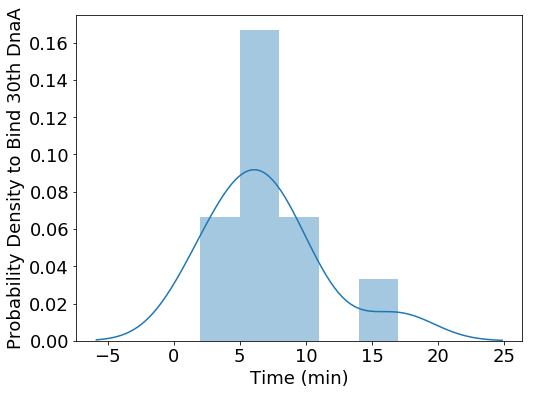

In [40]:

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,6))
sns.distplot(BindTimesMin)
# plt.title('Probability Distribution of 30th DnaA Binding Times')
plt.xlabel('Time (min)')
plt.ylabel('Probability Density to Bind 30th DnaA')

totalTimes=0
for bindTime in BindTimesMin:
    totalTimes = totalTimes + bindTime
print(totalTimes/len(BindTimesMin))


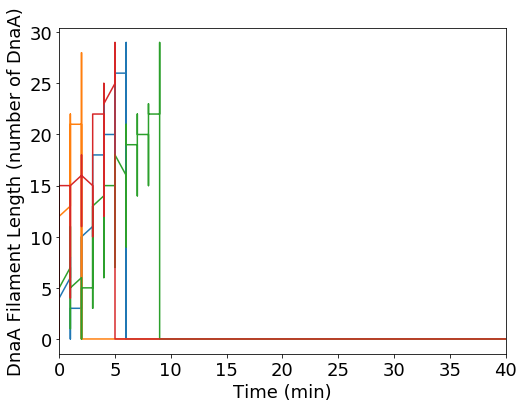

In [41]:
repnums = [1,2,3,4] # set the replicate number to be graphed here

def SumBoundsites(rep): # input for function is the replicate number
    base = []  # creates empty list

    for x in range(simtime+1): # fills list with zeros, with length equal to total time 
        base.append(0) 
    
    for i in range(30):  #loop 30 times (for each binding site)
        specName = 'ssDNABoundSite_' + str(i+1)  
        trace = getSpecieTrace(fh, specName, replicate = rep)  # gets the data for binding site i
        base = base + trace # comes in the form of a list so just sum it with the components of the base list
    return base  


fh = openLMFile(filename)

plt.figure(figsize=(8,6))

for rep in repnums:
    totalDnaA = SumBoundsites(rep)
    time = np.arange(0,simtime+1,1) 
    plt.plot(time/60,totalDnaA)
    
# title = 'Total Number of DnaA bound for Replicate ' + str(repnum)
# plt.title(title)
plt.xlim(0,40)
plt.ylabel('DnaA Filament Length (number of DnaA)')
plt.xlabel('Time (min)')

closeLMFile(fh)

## Create Definitions to Plot Single Replicates and Averages

### Randomly sample 10 single replicates

In [42]:
def PlotSpecies(species):
    fileHandle=openLMFile(filename)
    for i in range(1,min(reps,10)):
#         plotTraceFromFile(filename, [species], i, species + ".%d.png"%(i))
        plotTrace(fileHandle, [species],i)
        plt.show()
    closeLMFile(fileHandle)

/usr/local/lib/python/pySTDLM/PostProcessing.py:162: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(True)
/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:913: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python2.7/site-packages/matplotlib/rcsetup.py:158: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


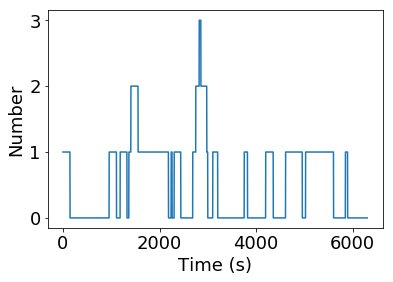

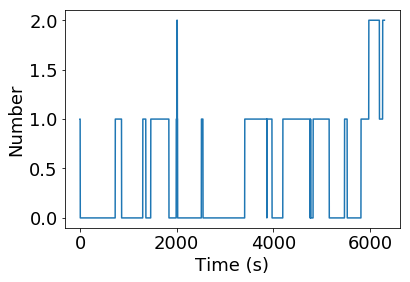

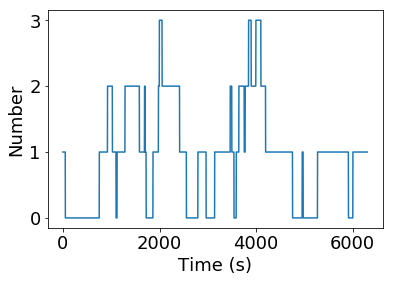

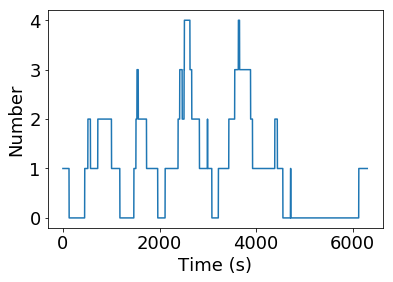

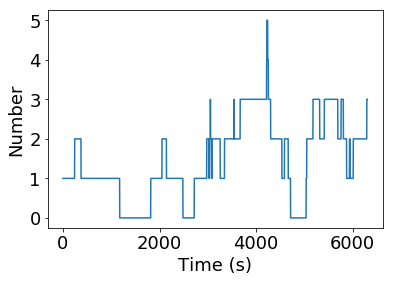

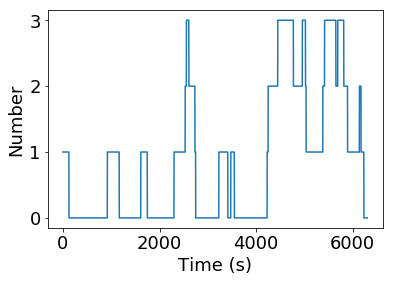

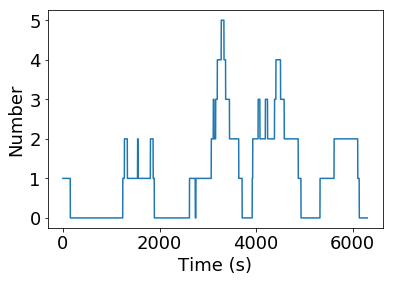

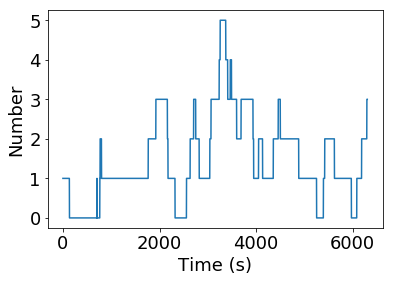

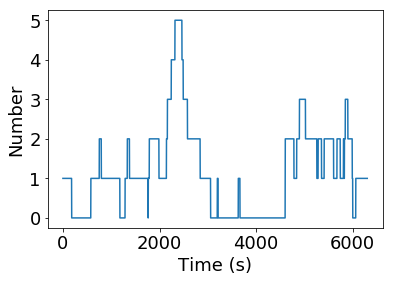

In [43]:
PlotSpecies("M_RNA_JCVISYN3A_0445_c")

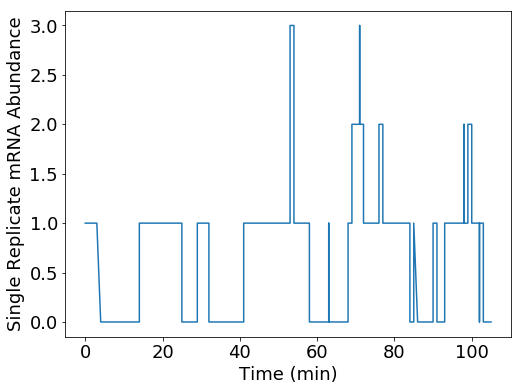

In [44]:
# Plot of a single replicate of gene 0445; glucose-6-phosphate isomerase.
# Note due to stochasticity, this plot will be completely different for every replicate and different among rerunning the sim.

fileHandle=openLMFile(filename)
specName = "M_RNA_JCVISYN3A_0445_c"
# Choose a replicate number to plot.
replicat = 10
trace = getSpecieTrace(fileHandle, specName, replicate = replicat)
time = np.arange(0,simtime+1,1)
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,6))
plt.plot(time/60,trace)
plt.ylabel('Single Replicate mRNA Abundance')
plt.xlabel('Time (min)')
closeLMFile(fileHandle)

In [45]:
# Create a definition to average each replicate from the simulation at each time point.

def AverageSpec(specName):
    fileHandle=openLMFile(filename)
    simTotal = np.zeros(simtime+1)
    simAvg = []
    
    for rep in range(1,reps+1):
#         base = []
#         for x in range(6000): # fills list with zeros, with length equal to total time 
#             base.append(0)
        trace = getSpecieTrace(fileHandle, specName, replicate = rep)
#         base = base + trace # comes in the form of a list so just sum it with the components of the base list
        simTotal += trace
        
    for index in simTotal:
        index_avg = index/reps
        simAvg.append(index_avg)
        
#     closeLMFile(filename)
    
    return simAvg

### Stop evaluation here if you don't want to immediately make every plot.
### Warning: For 1000 replicates, averaging the data can take hours if you make every plot

In [46]:
# import stop_evaluation 
# Uncomment or comment out the line above with "ctrl /"" if you want the notebook to stop evaluation before making plots.

Text(0,0.5,'Average DNA Copy Number')

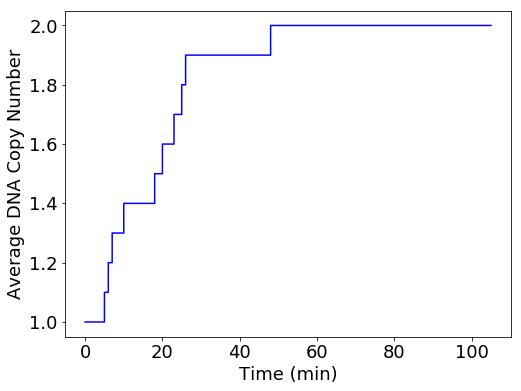

In [47]:
# Plot of average gene duplication (used gene 0067).  There are a few other species to look at if interested.

time = np.arange(0,simtime+1,1) # list of time steps, for x axis
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,6))
# plt.plot(time,AverageSpec("ssDNABoundSite_30"),'g')
plt.plot(time/60,AverageSpec('JCVISYN3A_0067_gene'),'b')
# plt.plot(time/60,AverageSpec('M_RNA_JCVISYN3A_0001_c'), 'g')
# plt.plot(time/60,AverageSpec('M_DnaA_c'), 'g')
# plt.plot(time/60,AverageSpec('ssDNAunboundSite_29'), 'g')
# plt.title('Average')
plt.xlabel('Time (min)')
plt.ylabel('Average DNA Copy Number')

Text(0,0.5,'Average Abundance of Free DnaA')

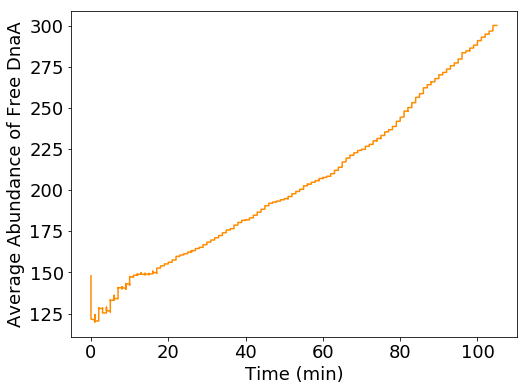

In [48]:
# Plot of average free (unbound) DnaA count.

time = np.arange(0,simtime+1,1) # list of time steps, for x axis
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,6))

plt.plot(time/60,AverageSpec('M_DnaA_c'), 'darkorange')

plt.xlabel('Time (min)')
plt.ylabel('Average Abundance of Free DnaA')

Text(0,0.5,'rRNA Generated')

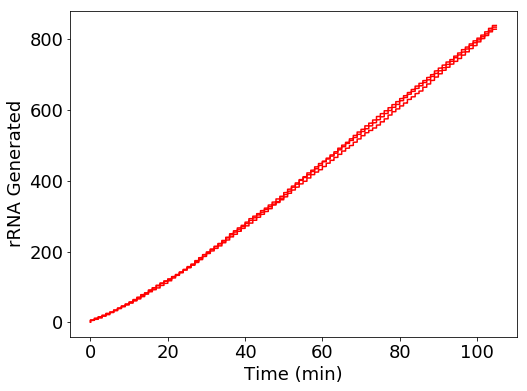

In [49]:
rrna_spec = ['M_rRNA_5S_c','M_rRNA_16S_c','M_rRNA_23S_c']

plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(8,6))

time = np.arange(0,simtime+1,1)

for rRNA in rrna_spec:
    plt.plot(time/60,AverageSpec(rRNA),'r')
    
plt.xlabel('Time (min)')
plt.ylabel('rRNA Generated')

Text(0,0.5,'Average mRNA Abundance')

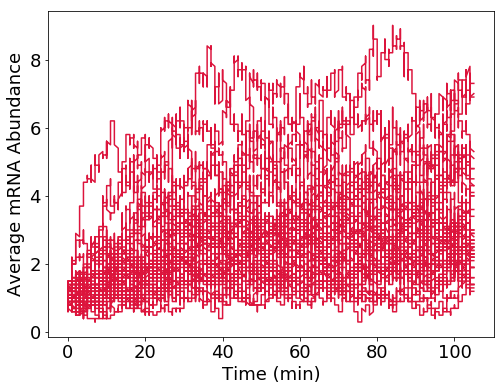

In [50]:
# Average mRNA counts for ribosomal protein coding mRNA.

metListmRNA = []

# for rnaID in ModelSpecies:
#     if "RNA_MMS" in rnaID:
#         metListmRNA.append(rnaID)


plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(8,6))

time = np.arange(0,simtime+1,1)

# for mmcode in gene_list_other:
#     mRNA = "M_RNA_" + mmcode + "_c"
#     metListmRNA.append(mRNA)
#     plt.plot(time/60,AverageSpec(mRNA),'y')

for index, row in riboPtnMetDF.iterrows():
    mmcode = row["gene"]
    LocusNum = mmcode.split('_')[1]
    JCVI3AID = "JCVISYN3A_" + LocusNum
    mRNA = "M_RNA_" + JCVI3AID + "_c"
    metListmRNA.append(mRNA)
    avgTrace = AverageSpec(mRNA)
#     plt.plot(time/60,AverageSpec(mRNA),'crimson')
    plt.plot(time/60,avgTrace,'crimson')
#     if avgTrace[-1] > 4:
#         print(mRNA,':',avgTrace[-1])
#     if avgTrace[-1] < 1.5:
#         print(mRNA,':',avgTrace[-1])
        
    
# metListmRNA.append("M_RNA_JCVISYN3A_0001_c")
    

        
# for index, row in riboPtnMetDF.iterrows():
#     mmcode = row["gene"]
#     LocusNum = mmcode.split('_')[1]
#     JCVI3AID = "JCVISYN3A_" + LocusNum
#     mRNA = "M_RNA_" + JCVI3AID + "_c"
# #     metListmRNA.append(mRNA)
#     plt.plot(time/60,AverageSpec(mRNA),'crimson')
        
# for mmcode in MetPtnGenes:
#     LocusNum = mmcode.split('_')[1]
#     JCVI3AID = "JCVISYN3A_" + LocusNum
#     mRNA = "M_RNA_" + JCVI3AID + "_c"
# #     metListmRNA.append(mRNA)
#     plt.plot(time/60,AverageSpec(mRNA),'g')
        
# plt.plot(time/60,AverageSpec("M_RNA_JCVISYN3A_0001_c"),'darkorange',linewidth = 4)
    
# print(len(metListmRNA))

# time = np.arange(0,simtime+1,1) # list of time steps, for x axis

# for mrna in metListmRNA:
#     plt.plot(time/60,AverageSpec(mrna))

# plt.title('Average mRNA Abundance')
plt.xlabel('Time (min)')
plt.ylabel('Average mRNA Abundance')
    
# metListPtns

Text(0,0.5,'Average mRNA Abundance')

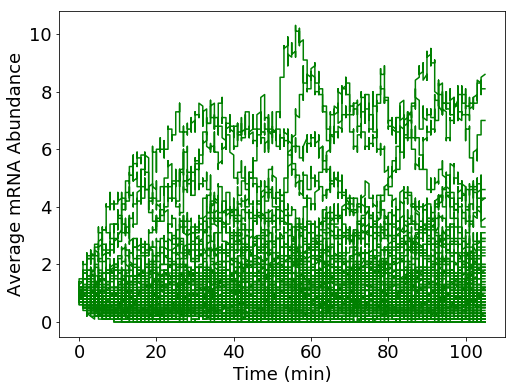

In [51]:
# Average mRNA counts for metabolic protein coding mRNA.

plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(8,6))

time = np.arange(0,simtime+1,1)

metListmRNA.append("M_RNA_JCVISYN3A_0065_c")
plt.plot(time/60,AverageSpec("M_RNA_JCVISYN3A_0065_c"),'g')

metListmRNA.append("M_RNA_JCVISYN3A_0621_c")
plt.plot(time/60,AverageSpec("M_RNA_JCVISYN3A_0621_c"),'g')


for mmcode in MetPtnGenes:
    LocusNum = mmcode.split('_')[1]
    JCVI3AID = "JCVISYN3A_" + LocusNum
    mRNA = "M_RNA_" + JCVI3AID + "_c"
    metListmRNA.append(mRNA)
    plt.plot(time/60,AverageSpec(mRNA),'g')
#     plt.plot(time/60,AverageSpec(mRNA),'g')
plt.xlabel('Time (min)')
plt.ylabel('Average mRNA Abundance')

83


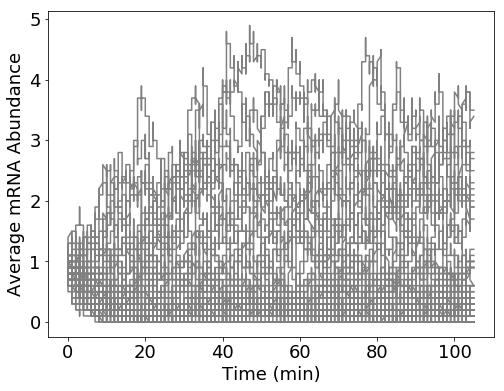

In [52]:
# Average mRNA counts for unclear function protein coding mRNA.

unclear = 0

NEWmRNA = []

plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(8,6))

time = np.arange(0,simtime+1,1)

NEWmRNA.append('M_RNA_JCVISYN3A_0918_c')
NEWmRNA.append('M_RNA_JCVISYN3A_0913_c')
NEWmRNA.append('M_RNA_JCVISYN3A_0930_c')
NEWmRNA.append('M_RNA_JCVISYN3A_0931_c')
NEWmRNA.append('M_RNA_JCVISYN3A_0932_c')
NEWmRNA.append('M_RNA_JCVISYN3A_0154_c')

for rnaID in NEWmRNA:
    metListmRNA.append(rnaID)
    plt.plot(time/60,AverageSpec(rnaID),'gray')

for rnaID in ModelSpecies:
    if ("RNA_JCVI" in rnaID) and (rnaID not in metListmRNA):
        
        locus_code = rnaID.split('3A_')[1].replace('_c','')
        mmcode = 'MMSYN1_' + locus_code

        function = annotatPD.loc[ annotatPD.iloc[:,5] == mmcode ].iloc[0, 10].strip()
        if 'clear' in function:
            unclear = unclear + 1

            metListmRNA.append(rnaID)
            plt.plot(time/60,AverageSpec(rnaID),'gray')

plt.xlabel('Time (min)')
plt.ylabel('Average mRNA Abundance')
            
print(unclear)

Text(0,0.5,'Average mRNA Abundance')

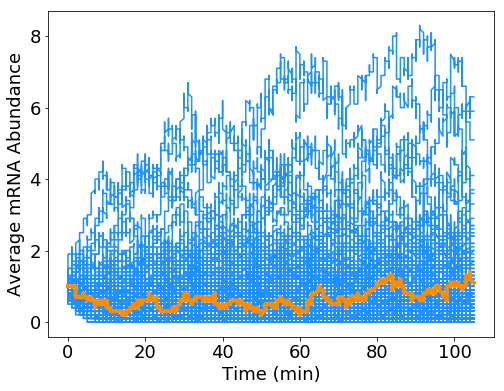

In [53]:
# Average mRNA counts for genetic information processing and cell division protein coding mRNA.

plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(8,6))

time = np.arange(0,simtime+1,1)

metListmRNA.append('M_RNA_JCVISYN3A_0001_c')

for rnaID in ModelSpecies:
    if ("RNA_JCVI" in rnaID) and (rnaID not in metListmRNA):
        metListmRNA.append(rnaID)
        plt.plot(time/60,AverageSpec(rnaID),'dodgerblue')
        
plt.plot(time/60,AverageSpec('M_RNA_JCVISYN3A_0001_c'),'darkorange',linewidth = 4)
        
plt.xlabel('Time (min)')
plt.ylabel('Average mRNA Abundance')

455


Text(0,0.5,'Average Total mRNA Abundance')

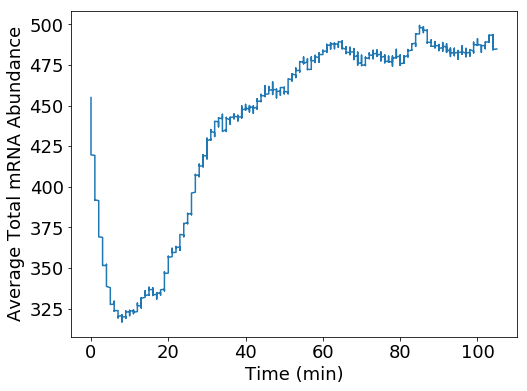

In [54]:
metListmRNA = []

# for rnaID in ModelSpecies:
#     if "RNA_MMS" in rnaID:
#         metListmRNA.append(rnaID)


plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(8,6))

time = np.arange(0,simtime+1,1)

# for mmcode in gene_list_other:
#     mRNA = "M_RNA_" + mmcode + "_c"
#     metListmRNA.append(mRNA)
#     plt.plot(time/60,AverageSpec(mRNA),'y')

for index, row in riboPtnMetDF.iterrows():
    mmcode = row["gene"]
    LocusNum = mmcode.split('_')[1]
    JCVI3AID = "JCVISYN3A_" + LocusNum
    mRNA = "M_RNA_" + JCVI3AID + "_c"
    metListmRNA.append(mRNA)
#     plt.plot(time/60,AverageSpec(mRNA),'crimson')
        
for mmcode in MetPtnGenes:
    LocusNum = mmcode.split('_')[1]
    JCVI3AID = "JCVISYN3A_" + LocusNum
    mRNA = "M_RNA_" + JCVI3AID + "_c"
    metListmRNA.append(mRNA)
#     plt.plot(time/60,AverageSpec(mRNA),'g')


    
metListmRNA.append("M_RNA_JCVISYN3A_0001_c")

    
for rnaID in ModelSpecies:
    if ("RNA_JCVI" in rnaID) and (rnaID not in metListmRNA):
        metListmRNA.append(rnaID)
#         plt.plot(time/60,AverageSpec(rnaID),'dodgerblue')
        
# plt.plot(time/60,AverageSpec("M_RNA_JCVISYN3A_0001_c"),'darkorange',linewidth = 4)
    
print(len(metListmRNA))

Total_mRNA = np.zeros(6301)

for mRNA in metListmRNA:
    avg_abund = AverageSpec(mRNA)
#     print(mRNA,' : ',avg_abund[-1])
    Total_mRNA = Total_mRNA + avg_abund
    
plt.plot(time/60,Total_mRNA)

# time = np.arange(0,simtime+1,1) # list of time steps, for x axis

# for mrna in metListmRNA:
#     plt.plot(time/60,AverageSpec(mrna))

# plt.title('Average mRNA Abundance')
plt.xlabel('Time (min)')
plt.ylabel('Average Total mRNA Abundance')
    
# metListPtns

Text(0,0.5,'Average tRNA Generated')

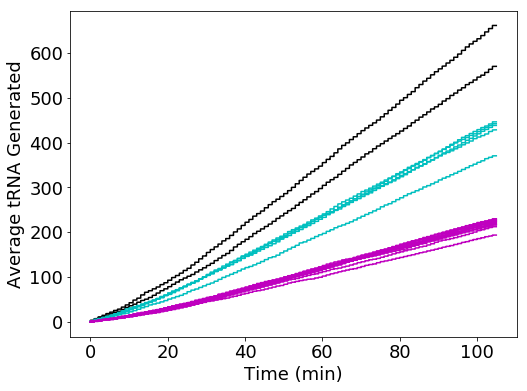

In [55]:
time = np.arange(0,simtime+1,1) # list of time steps, for x axis

plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(8,6))

metListtRNAmulti = []

trna_met_avg = AverageSpec('M_trnamet_c')
plt.plot(time/60,trna_met_avg - trna_met_avg[0],'k')
metListtRNAmulti.append('M_trnamet_c')

trna_leu_avg = AverageSpec('M_trnaleu_c')
plt.plot(time/60,trna_leu_avg - trna_leu_avg[0],'k')
metListtRNAmulti.append('M_trnaleu_c')

trna_thr_avg = AverageSpec('M_trnathr_c')
plt.plot(time/60,trna_thr_avg - trna_thr_avg[0],'c')
metListtRNAmulti.append('M_trnathr_c')

trna_trp_avg = AverageSpec('M_trnatrp_c')
plt.plot(time/60,trna_trp_avg - trna_trp_avg[0],'c')
metListtRNAmulti.append('M_trnatrp_c')

trna_lys_avg = AverageSpec('M_trnalys_c')
plt.plot(time/60,trna_lys_avg - trna_lys_avg[0],'c')
metListtRNAmulti.append('M_trnalys_c')

trna_arg_avg = AverageSpec('M_trnaarg_c')
plt.plot(time/60,trna_arg_avg - trna_arg_avg[0],'c')
metListtRNAmulti.append('M_trnaarg_c')

trna_ser_avg = AverageSpec('M_trnaser_c')
plt.plot(time/60,trna_ser_avg - trna_ser_avg[0],'c')
metListtRNAmulti.append('M_trnaser_c')

# metListtRNAmulti

metListtRNAsingle = []

for rnaID in ModelSpecies:
    if ("M_trna" in rnaID) and (rnaID not in metListtRNAmulti):
        metListtRNAsingle.append(rnaID)
        
for trna in metListtRNAsingle:
    trna_avg = AverageSpec(trna)
    plt.plot(time/60,trna_avg - trna_avg[0],'m')
    
plt.xlabel('Time (min)')
plt.ylabel('Average tRNA Generated')
        
# metListtRNAsingle

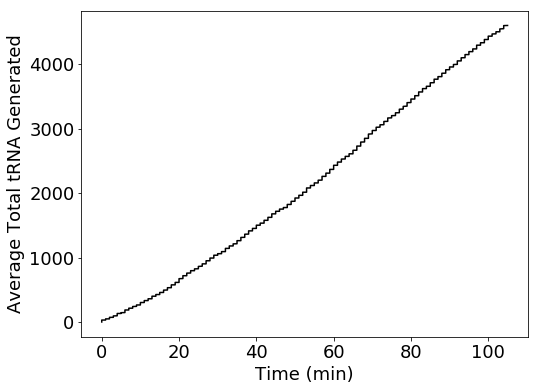

In [56]:
Total_trna = np.zeros(6301)

time = np.arange(0,simtime+1,1) # list of time steps, for x axis

plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(8,6))

for rnaID in ModelSpecies:
    
    if "M_trna" in rnaID:
        trna_avg = AverageSpec(trna)
        trna_formed = trna_avg - trna_avg[0]
        Total_trna = Total_trna + trna_formed
        
plt.xlabel('Time (min)')
plt.ylabel('Average Total tRNA Generated')
           
plt.plot(time/60,Total_trna,'k')

### Plot Protein Abundances

407


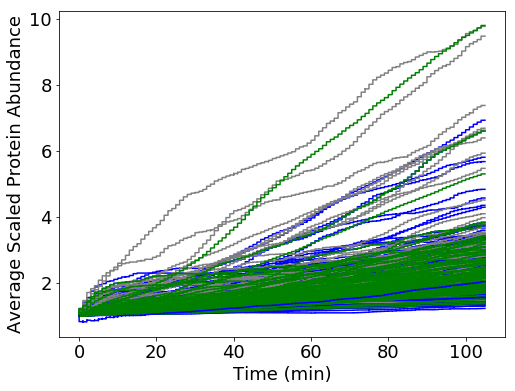

In [57]:
metListPtns = []

UnkPtns = []

metPtns = []

OtherPtns = []

NEWptn = []

# for ptnID in ModelSpecies:
#     if "PTN_JCVI" in ptnID:
#         metListPtns.append(ptnID)
        
time = np.arange(0,simtime+1,1) # list of time steps, for x axis

plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(8,6))

Low_proteomics = 0

for mmcode in MetPtnGenes:
    LocusNum = mmcode.split('_')[1]
    JCVI3AID = "JCVISYN3A_" + LocusNum
    ptn = "M_PTN_" + JCVI3AID + "_c"
    
    metPtns.append(ptn)
        
metListPtns.append('M_trdox_c')
metPtns.append('M_trdox_c')

metListPtns.append('M_apoACP_c')
metPtns.append('M_apoACP_c')

NEWptn.append('M_PTN_JCVISYN3A_0918_c')
NEWptn.append('M_PTN_JCVISYN3A_0913_c')
NEWptn.append('M_PTN_JCVISYN3A_0930_c')
NEWptn.append('M_PTN_JCVISYN3A_0931_c')
NEWptn.append('M_PTN_JCVISYN3A_0932_c')
NEWptn.append('M_PTN_JCVISYN3A_0154_c')

for ptnID in NEWptn:
    metListPtns.append(ptnID)
    
    UnkPtns.append(ptnID)

for ptnID in ModelSpecies:
    if ("PTN_JCVI" in ptnID) and (ptnID not in metListPtns):
        
        locus_code = ptnID.split('3A_')[1].replace('_c','')
        mmcode = 'MMSYN1_' + locus_code

        function = annotatPD.loc[ annotatPD.iloc[:,5] == mmcode ].iloc[0, 10].strip()
        
        if 'clear' in function:
            
            UnkPtns.append(ptnID)
            
            metListPtns.append(ptnID)
            
                
for ptnID in ModelSpecies:
    if ("PTN_JCVI" in ptnID) and (ptnID not in metListPtns):
        metListPtns.append(ptnID)
            
        avgTrace = AverageSpec(ptnID)
    
        proteomics = avgTrace[0]

        if proteomics > 10:
            scaled_abundance = avgTrace/proteomics
            plt.plot(time/60,scaled_abundance,'b')

        else:
            Low_proteomics = Low_proteomics + 1
            
for ptn in UnkPtns:
    avgTrace = AverageSpec(ptn)
    proteomics = avgTrace[0]
    
    if proteomics > 10:
        scaled_abundance = avgTrace/proteomics
        plt.plot(time/60,scaled_abundance,'gray')
        
    else:
        Low_proteomics = Low_proteomics + 1
        
for ptn in metPtns:
    avgTrace = AverageSpec(ptn)
    proteomics = avgTrace[0]
    
    if proteomics > 10:
        scaled_abundance = avgTrace/proteomics
        plt.plot(time/60,scaled_abundance,'g')
        
    else:
        Low_proteomics = Low_proteomics + 1
            
metListPtns.append('M_DnaA_c')
avgTrace = AverageSpec('M_DnaA_c')
proteomics = avgTrace[0]
scaled_abundance = avgTrace/proteomics
plt.plot(time/60,scaled_abundance,'b')
        
plt.xlabel('Time (min)')
plt.ylabel('Average Scaled Protein Abundance')

print(len(metListPtns))

In [58]:
PtnDistList = []
PtnDist = []

for ptnID in ModelSpecies:
    if "PTN_JCVI" in ptnID:
        PtnDistList.append(ptnID)

for index, row in PtnMetDF.iterrows():
    result = row["species"]
    if result:
        PtnDistList.append( result )
        
for ptn in PtnDistList:
    avgTrace = AverageSpec(ptn)
    
    proteomics = avgTrace[0]
    
    if proteomics > 10:
        scaledAvg = avgTrace[-1]/avgTrace[0]
        PtnDist.append(scaledAvg)

(0, 10.5)

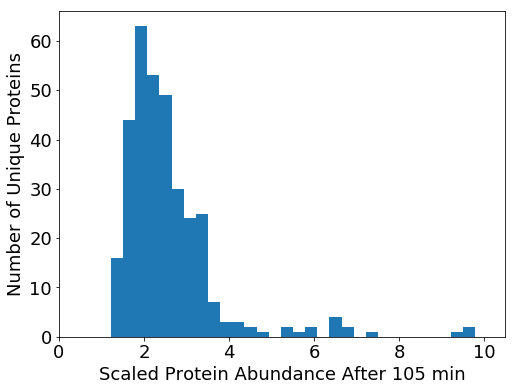

In [59]:
# Histogram of the protein counts scaled to their proteomics count at 105 minutes.

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,6))
plt.hist(PtnDist, bins=30)
# plt.title('Probability Distribution of 30th DnaA Binding Times')
plt.xlabel('Scaled Protein Abundance After 105 min')
plt.ylabel('Number of Unique Proteins')
plt.xlim(0,10.5)

In [60]:
# print('Proteins with proteomics below 10 or no proteomics: ', Low_proteomics)

### Print out details for proteins underproduced, overproduced, and just right.

In [61]:
# ANALYSIS OF UNDERPRODUCED PROTEINS

metListPtns = []

for ptnID in ModelSpecies:
    if "PTN_JCVI" in ptnID:
        metListPtns.append(ptnID)

for index, row in PtnMetDF.iterrows():
    result = row["species"]
    if result:
        metListPtns.append( result )
# metListPtns.append('M_trdox_c')        
# metListPtns.remove('M_PTN_MMSYN1_0689_c')
# print(metIDListRiboPtn)
        
time = np.arange(0,simtime+1,1) # list of time steps, for x axis

# plt.rcParams.update({'font.size': 18})

# plt.figure(figsize=(8,6))

lowPtns = 0

for ptn in metListPtns:
    avgTrace = AverageSpec(ptn)
    
    proteomics = avgTrace[0]
    
    if proteomics > 10:
        scaled_abundance = avgTrace/proteomics
#         plt.plot(time/60,scaled_abundance)
#         if scaled_abundance[-1] > 4:
#             print(ptn,proteomics,scaled_abundance[-1])
            
        if scaled_abundance[-1]<1.5:
            lowPtns = lowPtns + 1
            locus_code = ptn.split('3A_')[1].replace('_c','')
            mmcode = 'MMSYN1_' + locus_code
            # Checks if a translation to JCVISYN2* code is available

            ptnName = annotatPD.loc[ annotatPD.iloc[:,5] == mmcode ].iloc[0, 8].strip()
            GeneLength = annotatPD.loc[ annotatPD.iloc[:,5] == mmcode ].iloc[0, 2]
            function = annotatPD.loc[ annotatPD.iloc[:,5] == mmcode ].iloc[0, 10].strip()
            
                
            print(lowPtns,': ',ptnName)
            print('Function: ',function)
            print('Gene Length: ',GeneLength)
            print('Model ID: ',ptn)
            print('Proteomics: ',proteomics)
            print('Scaled Abundance after 105 min: ',scaled_abundance[-1])
            print(ptn,proteomics,scaled_abundance[-1])
            print()

# plt.title('Average ptn Pop')
# plt.xlabel('Time (min)')
# plt.ylabel('Average Scaled Protein Abundance')
    
# metListPtns

(1, ': ', u'polA: DNA polymerase I')
('Function: ', u'DNA replication')
('Gene Length: ', 2736.0)
('Model ID: ', 'M_PTN_JCVISYN3A_0611_c')
('Proteomics: ', 101.0)
('Scaled Abundance after 105 min: ', 1.4108910891089108)
('M_PTN_JCVISYN3A_0611_c', 101.0, 1.4108910891089108)
()
(2, ': ', u'valRS')
('Function: ', u'Translation')
('Gene Length: ', 2619.0)
('Model ID: ', 'M_PTN_JCVISYN3A_0260_c')
('Proteomics: ', 225.0)
('Scaled Abundance after 105 min: ', 1.484888888888889)
('M_PTN_JCVISYN3A_0260_c', 225.0, 1.484888888888889)
()
(3, ': ', u'hypothetical protein')
('Function: ', u'Unclear')
('Gene Length: ', 3159.0)
('Model ID: ', 'M_PTN_JCVISYN3A_0033_c')
('Proteomics: ', 61.0)
('Scaled Abundance after 105 min: ', 1.4606557377049179)
('M_PTN_JCVISYN3A_0033_c', 61.0, 1.4606557377049179)
()
(4, ': ', u'DNA topoisomerase IV, A subunit')
('Function: ', u'DNA topology')
('Gene Length: ', 2697.0)
('Model ID: ', 'M_PTN_JCVISYN3A_0453_c')
('Proteomics: ', 156.0)
('Scaled Abundance after 105 min: '

In [62]:
# ANALYSIS OF OVERPRODUCED PROTEINS

metListPtns = []

for ptnID in ModelSpecies:
    if "PTN_JCVI" in ptnID:
        metListPtns.append(ptnID)

for index, row in PtnMetDF.iterrows():
    result = row["species"]
    if result:
        metListPtns.append( result )
# metListPtns.append('M_trdox_c')        
# metListPtns.remove('M_PTN_MMSYN1_0689_c')
# print(metIDListRiboPtn)
        
time = np.arange(0,simtime+1,1) # list of time steps, for x axis

# plt.rcParams.update({'font.size': 18})

# plt.figure(figsize=(8,6))

highPtns = 0

for ptn in metListPtns:
    avgTrace = AverageSpec(ptn)
    
    proteomics = avgTrace[0]
    
    if proteomics > 10:
        scaled_abundance = avgTrace/proteomics
#         plt.plot(time/60,scaled_abundance)
        
        if scaled_abundance[-1] > 4:
            highPtns = highPtns + 1
            
            if 'JCVISYN3A' in ptn:
                locus_code = ptn.split('3A_')[1].replace('_c','')
                mmcode = 'MMSYN1_' + locus_code
                # Checks if a translation to JCVISYN2* code is available

                ptnName = annotatPD.loc[ annotatPD.iloc[:,5] == mmcode ].iloc[0, 8].strip()
                GeneLength = annotatPD.loc[ annotatPD.iloc[:,5] == mmcode ].iloc[0, 2]
                function = annotatPD.loc[ annotatPD.iloc[:,5] == mmcode ].iloc[0, 10].strip()
            else:
                GeneLength = ''
                ptnName = ''
                
            print(highPtns,': ',ptnName)
            print('Function: ',function)
            print('Model ID: ',ptn)
            print('Gene Length: ',GeneLength)
            print('Proteomics: ',proteomics)
            print('Scaled Abundance after 105 min: ',scaled_abundance[-1])
            print()
            
#         if scaled_abundance[-1]<1.5:
#             print(ptn,proteomics,scaled_abundance[-1])
#     else:
#         print(ptn,avgTrace[0],avgTrace[-1]/avgTrace[0])

# plt.title('Average ptn Pop')
# plt.xlabel('Time (min)')
# plt.ylabel('Average Scaled Protein Abundance')
    
    #trdox length = 309 nt
    #apoACP length  = 222 nt
    
# metListPtns

(1, ': ', u'PF04327 family protein')
('Function: ', u'Unclear')
('Model ID: ', 'M_PTN_JCVISYN3A_0500_c')
('Gene Length: ', 264.0)
('Proteomics: ', 42.0)
('Scaled Abundance after 105 min: ', 5.461904761904762)
()
(2, ': ', u'Sigma3 and sigma4 domains of RNA polymerase sigma factors?')
('Function: ', u'Regulation')
('Model ID: ', 'M_PTN_JCVISYN3A_0430_c')
('Gene Length: ', 336.0)
('Proteomics: ', 41.0)
('Scaled Abundance after 105 min: ', 4.826829268292683)
()
(3, ': ', u'gatC: aspartyl/glutamyl-tRNA(Asn/Gln) amidotransferase, C subunit')
('Function: ', u'Translation')
('Model ID: ', 'M_PTN_JCVISYN3A_0689_c')
('Gene Length: ', 297.0)
('Proteomics: ', 87.0)
('Scaled Abundance after 105 min: ', 6.594252873563219)
()
(4, ': ', u'hypothetical protein')
('Function: ', u'Unclear')
('Model ID: ', 'M_PTN_JCVISYN3A_0388_c')
('Gene Length: ', 618.0)
('Proteomics: ', 86.0)
('Scaled Abundance after 105 min: ', 4.087209302325581)
()
(5, ': ', u'PF03672 family protein')
('Function: ', u'Unclear')
('Mo

In [63]:
# ANALYSIS OF PROTEINS WITHIN 10% OF BEING DOUBLED

metListPtns = []

for ptnID in ModelSpecies:
    if "PTN_JCVI" in ptnID:
        metListPtns.append(ptnID)

for index, row in PtnMetDF.iterrows():
    result = row["species"]
    if result:
        metListPtns.append( result )
# metListPtns.append('M_trdox_c')        
# metListPtns.remove('M_PTN_MMSYN1_0689_c')
# print(metIDListRiboPtn)
        
time = np.arange(0,simtime+1,1) # list of time steps, for x axis

# plt.rcParams.update({'font.size': 18})

# plt.figure(figsize=(8,6))

highPtns = 0

for ptn in metListPtns:
    avgTrace = AverageSpec(ptn)
    
    proteomics = avgTrace[0]
    
    if proteomics > 10:
        scaled_abundance = avgTrace/proteomics
#         plt.plot(time/60,scaled_abundance)
        
        if (scaled_abundance[-1] > 1.7) and (scaled_abundance[-1] < 2.3):
            highPtns = highPtns + 1
            
            if 'JCVISYN3A' in ptn:
                locus_code = ptn.split('3A_')[1].replace('_c','')
                mmcode = 'MMSYN1_' + locus_code
                # Checks if a translation to JCVISYN2* code is available

                ptnName = annotatPD.loc[ annotatPD.iloc[:,5] == mmcode ].iloc[0, 8].strip()
                GeneLength = annotatPD.loc[ annotatPD.iloc[:,5] == mmcode ].iloc[0, 2]
                function = annotatPD.loc[ annotatPD.iloc[:,5] == mmcode ].iloc[0, 10].strip()
            else:
                GeneLength = ''
                ptnName = ''
                
            print(highPtns,': ',ptnName)
            print('Function: ',function)
            print('Model ID: ',ptn)
            print('Gene Length: ',GeneLength)
            print('Proteomics: ',proteomics)
            print('Scaled Abundance after 105 min: ',scaled_abundance[-1])
            print()
            
#         if scaled_abundance[-1]<1.5:
#             print(ptn,proteomics,scaled_abundance[-1])
#     else:
#         print(ptn,avgTrace[0],avgTrace[-1]/avgTrace[0])

# plt.title('Average ptn Pop')
# plt.xlabel('Time (min)')
# plt.ylabel('Average Scaled Protein Abundance')
    
    #trdox length = 309 nt
    #apoACP length  = 222 nt
    
# metListPtns

(1, ': ', u'pheRS (alpha)')
('Function: ', u'Translation')
('Model ID: ', 'M_PTN_JCVISYN3A_0529_c')
('Gene Length: ', 1053.0)
('Proteomics: ', 290.0)
('Scaled Abundance after 105 min: ', 2.1817241379310346)
()
(2, ': ', u'DNA polymerase III, beta subunit')
('Function: ', u'DNA replication')
('Model ID: ', 'M_PTN_JCVISYN3A_0002_c')
('Gene Length: ', 1128.0)
('Proteomics: ', 213.0)
('Scaled Abundance after 105 min: ', 1.9042253521126762)
()
(3, ': ', u'ftsA')
('Function: ', u'Cell division')
('Model ID: ', 'M_PTN_JCVISYN3A_0523_c')
('Gene Length: ', 1161.0)
('Proteomics: ', 51.0)
('Scaled Abundance after 105 min: ', 2.0274509803921568)
()
(4, ': ', u'HAD hydrolase, family IIB')
('Function: ', u'Unclear')
('Model ID: ', 'M_PTN_JCVISYN3A_0728_c')
('Gene Length: ', 837.0)
('Proteomics: ', 105.0)
('Scaled Abundance after 105 min: ', 2.220952380952381)
()
(5, ': ', u'pgm_bpd_ind: phosphoglycerate mutase (2,3-diphosphoglycerate-independent)')
('Function: ', u'Glucose transport & catabolism')
(

(37, ': ', u'lgt: phosphatidylglycerol-prolipoprotein diacylglyceryl transferase')
('Function: ', u'Lipid salvage and biogenesis')
('Model ID: ', 'M_PTN_JCVISYN3A_0818_c')
('Gene Length: ', 1431.0)
('Proteomics: ', 55.0)
('Scaled Abundance after 105 min: ', 2.161818181818182)
()
(38, ': ', u'hrcA: heat-inducible transcription repressor HrcA')
('Function: ', u'Regulation')
('Model ID: ', 'M_PTN_JCVISYN3A_0544_c')
('Gene Length: ', 1023.0)
('Proteomics: ', 220.0)
('Scaled Abundance after 105 min: ', 2.2822727272727272)
()
(39, ': ', u'glf: UDP-GALP_mutase: UDP-galactopyranose mutase')
('Function: ', u'Lipid salvage and biogenesis')
('Model ID: ', 'M_PTN_JCVISYN3A_0814_c')
('Gene Length: ', 1188.0)
('Proteomics: ', 78.0)
('Scaled Abundance after 105 min: ', 2.0128205128205128)
()
(40, ': ', u'DnaJ_bact: chaperone protein DnaJ')
('Function: ', u'Protein folding')
('Model ID: ', 'M_PTN_JCVISYN3A_0541_c')
('Gene Length: ', 1119.0)
('Proteomics: ', 208.0)
('Scaled Abundance after 105 min: ', 

(72, ': ', u'GTPase_EngA: ribosome-associated GTPase EngA')
('Function: ', u'Ribosome biogenesis')
('Model ID: ', 'M_PTN_JCVISYN3A_0348_c')
('Gene Length: ', 1308.0)
('Proteomics: ', 34.0)
('Scaled Abundance after 105 min: ', 2.15)
()
(73, ': ', u'PF09903 family protein')
('Function: ', u'Unclear')
('Model ID: ', 'M_PTN_JCVISYN3A_0592_c')
('Gene Length: ', 1473.0)
('Proteomics: ', 79.0)
('Scaled Abundance after 105 min: ', 2.1468354430379746)
()
(74, ': ', u'GTPase_YlqF: ribosome biogenesis GTP-binding protein YlqF')
('Function: ', u'Ribosome biogenesis')
('Model ID: ', 'M_PTN_JCVISYN3A_0366_c')
('Gene Length: ', 951.0)
('Proteomics: ', 146.0)
('Scaled Abundance after 105 min: ', 2.139041095890411)
()
(75, ': ', u'ffh: signal recognition particle protein')
('Function: ', u'Protein export')
('Model ID: ', 'M_PTN_JCVISYN3A_0360_c')
('Gene Length: ', 1344.0)
('Proteomics: ', 365.0)
('Scaled Abundance after 105 min: ', 1.941095890410959)
()
(76, ': ', u'guanyl_kin: guanylate kinase')
('Fun

(109, ': ', u'pcrA')
('Function: ', u'DNA replication')
('Model ID: ', 'M_PTN_JCVISYN3A_0695_c')
('Gene Length: ', 2169.0)
('Proteomics: ', 218.0)
('Scaled Abundance after 105 min: ', 1.8504587155963301)
()
(110, ': ', u'peptidase')
('Function: ', u'Proteolysis')
('Model ID: ', 'M_PTN_JCVISYN3A_0479_c')
('Gene Length: ', 1647.0)
('Proteomics: ', 66.0)
('Scaled Abundance after 105 min: ', 1.7318181818181817)
()
(111, ': ', u'putative magnesium-importing ATPase')
('Function: ', u'Transport')
('Model ID: ', 'M_PTN_JCVISYN3A_0879_c')
('Gene Length: ', 2658.0)
('Proteomics: ', 80.0)
('Scaled Abundance after 105 min: ', 1.8050000000000002)
()
(112, ': ', u'pgsA: CDP-diacylglycerol--glycerol-3-phosphate 3-phosphatidyltransferase')
('Function: ', u'Lipid salvage and biogenesis')
('Model ID: ', 'M_PTN_JCVISYN3A_0875_c')
('Gene Length: ', 597.0)
('Proteomics: ', 36.0)
('Scaled Abundance after 105 min: ', 2.283333333333333)
()
(113, ': ', u'amino acid permease')
('Function: ', u'Transport')
('Mod

In [64]:
# # Print out messenger counts for a few proteins that are interesting for various reasons.

# Locus_of_int = ['0065','0621','0910','0238','0653','0662','0672','0607','0475','0290','0291','0804','0002','0216']

# for tag in Locus_of_int:
#     locusTag = 'JCVISYN3A_'+tag
#     mrnaID = 'M_RNA_'+locusTag+'_c'
#     avgTrace = AverageSpec(mrnaID)
#     print(locusTag,' : ',avgTrace[-1])
#     ptnID = 'M_PTN_'+locusTag+'_c'

In [65]:
# Get details for proteins in Central Metabolism.

# CentMetList = ['0213','0220','0221','0227','0228','0229','0230','0233','0234','0262','0316','0435','0445','0451','0475','0493','0494','0495','0606','0607','0694','0726','0727','0729','0733','0779','0800','0831']

# print(len(CentMetList))

# CentMetListPtns = []

# for locusNum in CentMetList:
#     ptnID = 'M_PTN_JCVISYN3A_' + locusNum + '_c'
#     CentMetListPtns.append(ptnID)

# for ptn in CentMetListPtns:
#     avgTrace = AverageSpec(ptn)
    
#     proteomics = avgTrace[0]
    
# #     if proteomics > 10:
#     scaled_abundance = avgTrace/proteomics
# #         plt.plot(time/60,scaled_abundance)
            
#     if 'JCVISYN3A' in ptn:
#         locus_code = ptn.split('3A_')[1].replace('_c','')
#         mmcode = 'MMSYN1_' + locus_code
#                 # Checks if a translation to JCVISYN2* code is available

#         ptnName = annotatPD.loc[ annotatPD.iloc[:,5] == mmcode ].iloc[0, 8].strip()
#         GeneLength = annotatPD.loc[ annotatPD.iloc[:,5] == mmcode ].iloc[0, 2]
#         function = annotatPD.loc[ annotatPD.iloc[:,5] == mmcode ].iloc[0, 10].strip()
#     else:
#         GeneLength = ''
#         ptnName = ''
        
#     print(ptnName)            
#     print('Function: ',function)
#     print('Model ID: ',ptn)
#     print('Gene Length: ',GeneLength)
#     print('Proteomics: ',proteomics)
#     print('Scaled Abundance after 105 min: ',scaled_abundance[-1])
#     print()

### Plot production of ribosomal proteins

Text(0,0.5,'Average Ribosomal Proteins Produced')

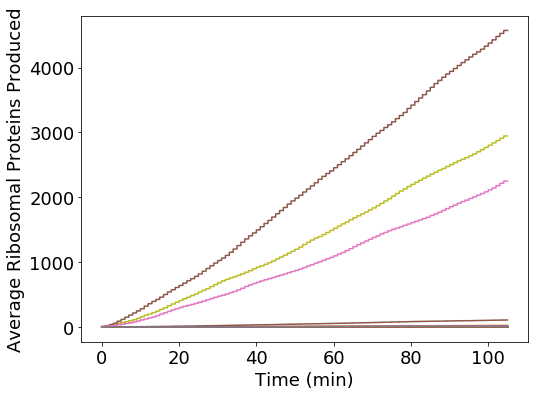

In [66]:
metIDListRiboPtn = []
for index, row in riboPtnMetDF.iterrows():
    result = row["species"]
    if result:
        metIDListRiboPtn.append( result )
# print(metIDListRiboPtn)

time = np.arange(0,simtime+1,1) # list of time steps, for x axis

plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(8,6))

for ptn in metIDListRiboPtn:
    avgTrace = AverageSpec(ptn)
#     plt.plot(time/60,avgTrace-avgTrace[0])
    plt.plot(time/60,avgTrace/avgTrace[0])
#     print(ptn,': ',avgTrace[0],': ',avgTrace[-1]-avgTrace[0])
#     print()

# plt.title('Average ptn production')
# plt.yscale('log')
plt.xlabel('Time (min)')
plt.ylabel('Average Ribosomal Proteins Produced')

In [67]:
metIDListRiboPtn = []
for index, row in riboPtnMetDF.iterrows():
    result = row["species"]
    if result:
        metIDListRiboPtn.append( result )
print(metIDListRiboPtn)

riboPtnDist = []
RiboPtnProteomics = ['Proteomics Count']
RiboPtnProd = ['Proteins Produced']

for ptn in metIDListRiboPtn:
    avgTrace = AverageSpec(ptn)
    ptnProduced = avgTrace[-1]-avgTrace[0]
    riboPtnDist.append(ptnProduced)
    RiboPtnProd.append(ptnProduced)
    RiboPtnProteomics.append(avgTrace[0])
    

['M_s4_c', 'M_s17_c', 'M_s15_c', 'M_s8_c', 'M_s20_c', 'M_s7_c', 'M_s16_c', 'M_s18_c', 'M_s9_c', 'M_s13_c', 'M_s19_c', 'M_s2_c', 'M_s11_c', 'M_s5_c', 'M_s14_c', 'M_s3_c', 'M_s10_c', 'M_s12_c', 'M_s21_c', 'M_L24_c', 'M_L18_c', 'M_L11_c', 'M_L20_c', 'M_L12_c', 'M_L4_c', 'M_L21_c', 'M_L5_c', 'M_L1_c', 'M_L13_c', 'M_L29_c', 'M_L2_c', 'M_L31_c', 'M_L3_c', 'M_L22_c', 'M_L15_c', 'M_L34_c', 'M_L23_c', 'M_L6_c', 'M_L14_c', 'M_L19_c', 'M_L27_c', 'M_L10_c', 'M_L9_c', 'M_L16_c', 'M_L28_c', 'M_L32_c', 'M_L35_c', 'M_L17_c']


Text(0.5,0,'Protein Count')

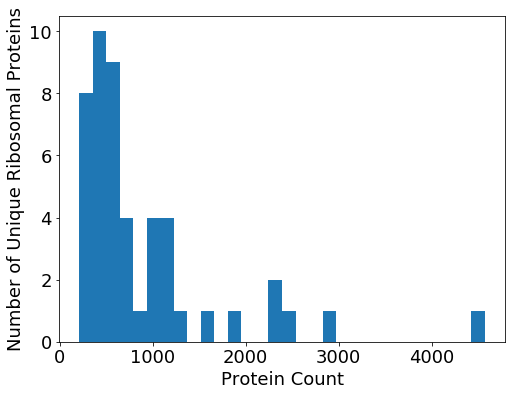

In [68]:
# Histogram of the number of each unique ribosomal protein produced.

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,6))
plt.hist(riboPtnDist, bins=30)
# plt.title('Probability Distribution of 30th DnaA Binding Times')
plt.ylabel('Number of Unique Ribosomal Proteins')
plt.xlabel('Protein Count')

In [69]:
print(metIDListRiboPtn)
print(riboPtnDist)

['M_s4_c', 'M_s17_c', 'M_s15_c', 'M_s8_c', 'M_s20_c', 'M_s7_c', 'M_s16_c', 'M_s18_c', 'M_s9_c', 'M_s13_c', 'M_s19_c', 'M_s2_c', 'M_s11_c', 'M_s5_c', 'M_s14_c', 'M_s3_c', 'M_s10_c', 'M_s12_c', 'M_s21_c', 'M_L24_c', 'M_L18_c', 'M_L11_c', 'M_L20_c', 'M_L12_c', 'M_L4_c', 'M_L21_c', 'M_L5_c', 'M_L1_c', 'M_L13_c', 'M_L29_c', 'M_L2_c', 'M_L31_c', 'M_L3_c', 'M_L22_c', 'M_L15_c', 'M_L34_c', 'M_L23_c', 'M_L6_c', 'M_L14_c', 'M_L19_c', 'M_L27_c', 'M_L10_c', 'M_L9_c', 'M_L16_c', 'M_L28_c', 'M_L32_c', 'M_L35_c', 'M_L17_c']
[512.3, 1105.9, 1109.7, 503.29999999999995, 1346.1, 365.5, 944.5, 1611.3, 553.7, 597.5, 1143.1, 208.39999999999998, 545.0, 318.79999999999995, 2504.4, 337.0, 927.5999999999999, 435.20000000000005, 2945.7, 751.3, 681.5, 442.20000000000005, 656.6, 596.5999999999999, 422.29999999999995, 974.4000000000001, 270.5, 353.1, 387.70000000000005, 425.5, 250.60000000000002, 1109.1, 360.5, 705.9000000000001, 442.29999999999995, 4572.2, 940.3, 256.9, 604.1, 545.0, 997.2, 315.6, 427.0, 465.70000

### Comparing the model to the proteomics distribution

In [70]:
# Get the proteomics count and count generated after 105 minutes for all proteins.

PtnDistList = []
PtnDist = []
ProteomeDist = []

def getProteomics(newMetID, jcvi2ID):
    
    # Check if protein quantification is available.
    try:
        if jcvi2ID.startswith("JCVIman_"):
            aoeID = manGPRPD.loc[ manGPRPD.MM == jcvi2ID.replace("JCVIman_",""), "AOE" ].values[0]
        else:
            aoeID = J2toAOE[ jcvi2ID ]
        
        ptnCount = max(0,round(proteomPD.loc[ proteomPD.Protein == aoeID ].iloc[0,21]))
#         
        ptnName  = proteomPD.loc[ proteomPD.Protein == aoeID ].iloc[0,1].replace(
            " [synthetic bacterium JCVI-Syn3.0]","")
        
#         ptnConcentration = ptnCount*countToMiliMol
    except:
        print("WARNING: No protein count for", newMetID)
        print("Using default protein concentration.")

        ptnName = newMetID
        ptnCount = 0
#         ptnConcentration = defaultPtnConcentration

        ptnNoQuant.add(newMetID)
    
    return ptnCount, ptnName

for ptnID in ModelSpecies:
    if "PTN_JCVI" in ptnID:
        PtnDistList.append(ptnID)
        
# for index, row in riboPtnMetDF.iterrows():
#     result = row["species"]
#     if result:
#         PtnDistList.append( result )

# for index, row in PtnMetDF.iterrows():
#     result = row["species"]
#     if result:
#         PtnDistList.append( result )
        
for ptn in PtnDistList:
    
    if 'JCVISYN3A' in ptn:
        
        locus_code = ptn.split('3A_')[1].replace('_c','')
        mmcode = 'MMSYN1_' + locus_code
        
        try:
            jcvi2ID = annotatPD.loc[ annotatPD.iloc[:,5] == mmcode ].iloc[0, 13].strip()
        except:
            jcvi2ID = "JCVIunk_" + mmcode

        ptnCount, ptnName = getProteomics(ptn, jcvi2ID)

    else:
        GeneLength = ''
        ptnName = ''
        ptnCount = 0
        print('No proteomics')
        
#     if 'clear' in function:
                
#             print(highPtns,': ',ptnName)
#             print('Function: ',function)
#             print('Model ID: ',ptn)
#             print('Gene Length: ',GeneLength)
#             print('Proteomics: ',proteomics)
#             print('Scaled Abundance after 105 min: ',scaled_abundance[-1])
#             print()
    
    proteomics = ptnCount
    
    if proteomics > 0:
        avgTrace = AverageSpec(ptn)
        final_count = avgTrace[-1] - avgTrace[0]
        
        ptnName = annotatPD.loc[ annotatPD.iloc[:,5] == mmcode ].iloc[0, 8].strip()
        GeneLength = annotatPD.loc[ annotatPD.iloc[:,5] == mmcode ].iloc[0, 2]
        function = annotatPD.loc[ annotatPD.iloc[:,5] == mmcode ].iloc[0, 10].strip()
        ProteomeDist.append(proteomics)
        PtnDist.append(final_count)

('WARNING: No protein count for', 'M_PTN_JCVISYN3A_0503_c')
Using default protein concentration.
('WARNING: No protein count for', 'M_PTN_JCVISYN3A_0913_c')
Using default protein concentration.
('WARNING: No protein count for', 'M_PTN_JCVISYN3A_0918_c')
Using default protein concentration.
('WARNING: No protein count for', 'M_PTN_JCVISYN3A_0525_c')
Using default protein concentration.
('WARNING: No protein count for', 'M_PTN_JCVISYN3A_0851_c')
Using default protein concentration.
('WARNING: No protein count for', 'M_PTN_JCVISYN3A_0263_c')
Using default protein concentration.
('WARNING: No protein count for', 'M_PTN_JCVISYN3A_0649_c')
Using default protein concentration.
('WARNING: No protein count for', 'M_PTN_JCVISYN3A_0648_c')
Using default protein concentration.
('WARNING: No protein count for', 'M_PTN_JCVISYN3A_0643_c')
Using default protein concentration.
('WARNING: No protein count for', 'M_PTN_JCVISYN3A_0852_c')
Using default protein concentration.
('WARNING: No protein count fo

(373, 373)


Text(0,0.5,'Number of Unique Proteins')

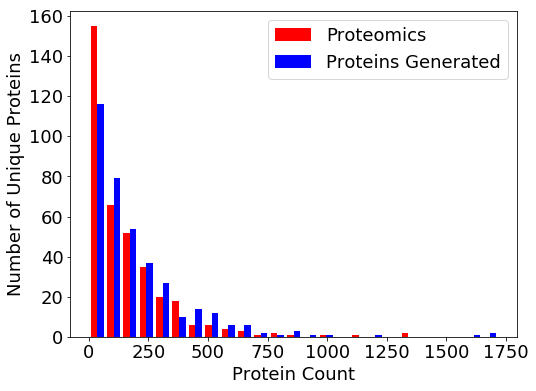

In [71]:
print(len(ProteomeDist),len(PtnDist))

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,6))
plt.hist((ProteomeDist,PtnDist),bins = 25,color = ['r','b'])
plt.legend(('Proteomics','Proteins Generated'))
# h1 = plt.hist(PtnDist, bins = 30, color = 'r')
# h2 = plt.hist(ProteomeDist, bins = 30, color = 'b')
# plt.title('Probability Distribution of 30th DnaA Binding Times')
plt.xlabel('Protein Count')
plt.ylabel('Number of Unique Proteins')
# plt.xscale('log')
# plt.xlim(1,10)

In [72]:
# Get the proteomics counts for all proteins with unclear function.

PtnDistList = []
# PtnDist = []
UncProteomeDist = []

def getProteomics(newMetID, jcvi2ID):
    
    # Check if protein quantification is available.
    try:
        if jcvi2ID.startswith("JCVIman_"):
            aoeID = manGPRPD.loc[ manGPRPD.MM == jcvi2ID.replace("JCVIman_",""), "AOE" ].values[0]
        else:
            aoeID = J2toAOE[ jcvi2ID ]
        
        ptnCount = max(0,round(proteomPD.loc[ proteomPD.Protein == aoeID ].iloc[0,21]))
#         
        ptnName  = proteomPD.loc[ proteomPD.Protein == aoeID ].iloc[0,1].replace(
            " [synthetic bacterium JCVI-Syn3.0]","")
        
#         ptnConcentration = ptnCount*countToMiliMol
    except:
#         print("WARNING: No protein count for", newMetID)
#         print("Using default protein concentration.")

        ptnName = newMetID
        ptnCount = 0
#         ptnConcentration = defaultPtnConcentration

        ptnNoQuant.add(newMetID)
    
    return ptnCount, ptnName

for ptnID in ModelSpecies:
    if "PTN_JCVI" in ptnID:
        PtnDistList.append(ptnID)
        
# for index, row in riboPtnMetDF.iterrows():
#     result = row["species"]
#     if result:
#         PtnDistList.append( result )

# for index, row in PtnMetDF.iterrows():
#     result = row["species"]
#     if result:
#         PtnDistList.append( result )
        
for ptn in PtnDistList:
    
    if 'JCVISYN3A' in ptn:
        
        locus_code = ptn.split('3A_')[1].replace('_c','')
        mmcode = 'MMSYN1_' + locus_code
        
        try:
            jcvi2ID = annotatPD.loc[ annotatPD.iloc[:,5] == mmcode ].iloc[0, 13].strip()
        except:
            jcvi2ID = "JCVIunk_" + mmcode

        ptnCount, ptnName = getProteomics(ptn, jcvi2ID)

    else:
        GeneLength = ''
        ptnName = ''
        ptnCount = 0
        print('No proteomics')
        
#     if 'clear' in function:
                
#             print(highPtns,': ',ptnName)
#             print('Function: ',function)
#             print('Model ID: ',ptn)
#             print('Gene Length: ',GeneLength)
#             print('Proteomics: ',proteomics)
#             print('Scaled Abundance after 105 min: ',scaled_abundance[-1])
#             print()
    
    proteomics = ptnCount
    
    if proteomics > 0:
#         avgTrace = AverageSpec(ptn)
#         final_count = avgTrace[-1] - avgTrace[0]
        
        ptnName = annotatPD.loc[ annotatPD.iloc[:,5] == mmcode ].iloc[0, 8].strip()
        GeneLength = annotatPD.loc[ annotatPD.iloc[:,5] == mmcode ].iloc[0, 2]
        function = annotatPD.loc[ annotatPD.iloc[:,5] == mmcode ].iloc[0, 10].strip()
        if 'clear' in function:
            print(ptn)
            print(ptnName)
            print(function)
            print(proteomics)
            print('')
            UncProteomeDist.append(proteomics)

M_PTN_JCVISYN3A_0005_c
hypothetical protein
Unclear
72.0

M_PTN_JCVISYN3A_0250_c
hypothetical protein
Unclear
262.0

M_PTN_JCVISYN3A_0728_c
HAD hydrolase, family IIB
Unclear
105.0

M_PTN_JCVISYN3A_0710_c
Cof-like hydrolase
Unclear
81.0

M_PTN_JCVISYN3A_0500_c
PF04327 family protein
Unclear
42.0

M_PTN_JCVISYN3A_0132_c
ATPase, AAA family
Unclear
93.0

M_PTN_JCVISYN3A_0139_c
DHHA1 domain protein
Unclear
187.0

M_PTN_JCVISYN3A_0138_c
hypothetical protein
Unclear
108.0

M_PTN_JCVISYN3A_0827_c
hypothetical protein
Unclear
212.0

M_PTN_JCVISYN3A_0438_c
Histidine triad (HIT) hydrolase-like protein
Unclear
197.0

M_PTN_JCVISYN3A_0431_c
putative metallophosphoesterase
Unclear
36.0

M_PTN_JCVISYN3A_0433_c
CutC family protein
Unclear
30.0

M_PTN_JCVISYN3A_0615_c
tRNA binding domain protein
Unclear
233.0

M_PTN_JCVISYN3A_0388_c
hypothetical protein
Unclear
86.0

M_PTN_JCVISYN3A_0389_c
PF11074 domain protein
Unclear
74.0

M_PTN_JCVISYN3A_0264_c
kinase domain protein
Unclear
1.0

M_PTN_JCVISYN3A_014

76


Text(0,0.5,'Number of Unique Proteins')

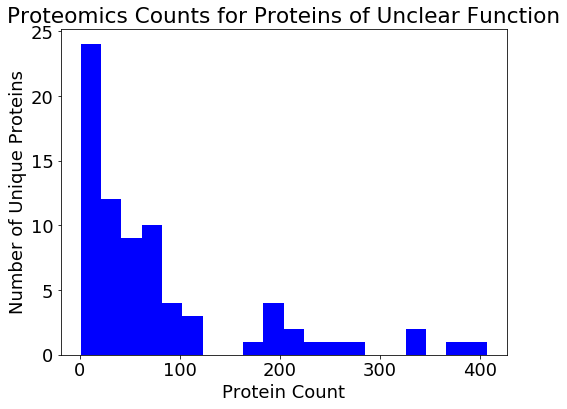

In [73]:
# Histogram of proteomics for proteins with unclear function.

print(len(UncProteomeDist))

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,6))
plt.hist(UncProteomeDist, bins = 20, color = 'b')
plt.title('Proteomics Counts for Proteins of Unclear Function')
plt.xlabel('Protein Count')
plt.ylabel('Number of Unique Proteins')
# plt.xscale('log')
# plt.xlim(1,10)

In [74]:
# Get kinetic and sequence data for ribosomal prorteins.

# with open("riboPtnInfo.csv", "a", newline='') as ltc:
#     wr = csv.writer(ltc, dialect='excel')
#     wr.writerow(RiboPtnNames)
    
# with open("riboPtnInfo.csv", "a", newline='') as ltc:
#     wr = csv.writer(ltc, dialect='excel')
#     wr.writerow(RiboPtnLens)
    
# with open("riboPtnInfo.csv", "a", newline='') as ltc:
#     wr = csv.writer(ltc, dialect='excel')
#     wr.writerow(RiboPtnTrscRates)
    
# with open("riboPtnInfo.csv", "a", newline='') as ltc:
#     wr = csv.writer(ltc, dialect='excel')
#     wr.writerow(RiboPtnTranslatRates)
    
# with open("riboPtnInfo.csv", "a", newline='') as ltc:
#     wr = csv.writer(ltc, dialect='excel')
#     wr.writerow(RiboPtnProteomics)
    
# with open("riboPtnInfo.csv", "a", newline='') as ltc:
#     wr = csv.writer(ltc, dialect='excel')
#     wr.writerow(RiboPtnProd)


## ATP Costs

('ATP_rep', ': ', 543380, ':', 26, 'mM')
('ATP_trsc', ': ', 10815826, ':', 535, 'mM')
('ATP_translat', ': ', 64649983, ':', 3203, 'mM')
('ATP_mRNAdeg', ': ', 6394965, ':', 316, 'mM')
('ATP_ptndeg', ': ', 1926414, ':', 95, 'mM')
('Total ATP Cost: ', 84330569.39999999, ':', 4178.935665195573)


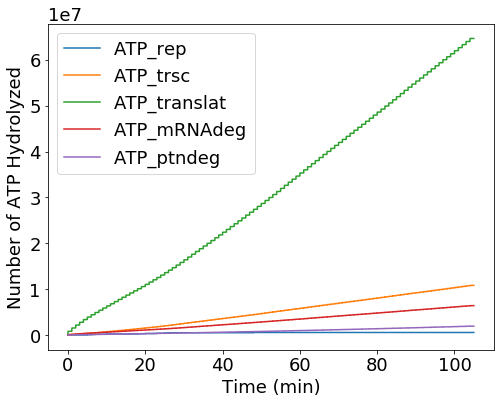

In [75]:
time = np.arange(0,simtime+1,1) # list of time steps, for x axis
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,6))

ATP_costs = ['ATP_rep','ATP_trsc','ATP_translat','ATP_mRNAdeg','ATP_ptndeg']

Total_ATP_cost = 0

for cost in ATP_costs:
    avgTrace = AverageSpec(cost)
    plt.plot(time/60,avgTrace)
    Total_ATP_cost = Total_ATP_cost + avgTrace[-1]
    print(cost,': ',int(avgTrace[-1]),':',int(avgTrace[-1]*countToMiliMol),'mM')

print('Total ATP Cost: ',Total_ATP_cost,':',Total_ATP_cost*countToMiliMol)    

# plt.yscale('log')
plt.xlabel('Time (min)')
plt.ylabel('Number of ATP Hydrolyzed')
plt.legend(ATP_costs)
